# Basic Setup

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

In [41]:
import os, sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (11,8)

In [42]:
import keras
import keras_resnet.models
shape, classes = (32, 32, 3), 10
x = keras.layers.Input(shape)
model = keras_resnet.models.ResNet50(x, classes=classes)
model.compile("adam", "categorical_crossentropy", ["accuracy"])
(training_x, training_y), (_, _) = keras.datasets.cifar10.load_data()
training_y = keras.utils.np_utils.to_categorical(training_y)
model.fit(training_x, training_y)

Epoch 1/1
50000/50000 [==============================] - 59s 1ms/step - loss: 14.5063 - acc: 0.1000


# ResNet

In [43]:
#Import kera library and other libaries

from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

In [44]:
#Set batch size, epochs and resnet depth

# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 50
data_augmentation = False 
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

In [45]:
#Data preparation

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [46]:
#Learning rate strategy

def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [47]:
#Create resnet layer

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            activation-bn-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [48]:
#Stacks of 2 x (3 x 3) Conv2D-BN-ReLU resnet

def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [49]:
#Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D resnet

def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]
    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [50]:
#Create resnet, train model and test model

if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Learning rate:  0.001
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 32, 32, 16)   64          conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_31 (Activation)      (None, 32, 32, 16)   0           batch_normalization_21[0][0]     
_______________________________________________________________________________________

Train on 50000 samples, validate on 10000 samples
Learning rate:  0.001
Epoch 1/50
50000/50000 [==============================] - 82s 2ms/step - loss: 1.4233 - acc: 0.5338 - val_loss: 1.6147 - val_acc: 0.4789
Learning rate:  0.001
Epoch 2/50
50000/50000 [==============================] - 75s 1ms/step - loss: 1.0324 - acc: 0.6844 - val_loss: 1.2812 - val_acc: 0.5999
Learning rate:  0.001
Epoch 3/50
50000/50000 [==============================] - 73s 1ms/step - loss: 0.8795 - acc: 0.7456 - val_loss: 1.1660 - val_acc: 0.6668
Learning rate:  0.001
Epoch 4/50
50000/50000 [==============================] - 75s 1ms/step - loss: 0.7877 - acc: 0.7794 - val_loss: 0.8796 - val_acc: 0.7556
Learning rate:  0.001
Epoch 5/50
50000/50000 [==============================] - 75s 1ms/step - loss: 0.7280 - acc: 0.8012 - val_loss: 0.8351 - val_acc: 0.7691
Learning rate:  0.001
Epoch 6/50
50000/50000 [==============================] - 75s 1ms/step - loss: 0.6755 - acc: 0.8235 - val_loss: 0.8868 - val_acc: 0.7

# LSTM

In [51]:
#LSTM and CNN for sequence classification in the IMDB dataset
#Import kera library and other needed libraries

import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import ModelCheckpoint

In [52]:
#Set parameters before training

# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset but only keep the top n words, zero the rest
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)
# truncate and pad input sequences
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)
# create the model
embedding_vecor_length = 32

In [53]:
#Create LSTM network and CNN for sequence classification

model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'LSTM_CNN_model.{epoch:03d}.h5' 
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='acc',
                             verbose=1,
                             save_best_only=True)
callbacks = [checkpoint]
model.fit(X_train, y_train, epochs=50, batch_size=64, callbacks=callbacks)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 500, 32)           3104      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 101       
Total params: 216,405
Trainable params: 216,405
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
25000/25000 [==============================] - 128s 5ms/step - loss: 0.4563 - acc: 0.7642
Epoch 2/50
25000/25000 [======

Epoch 27/50
25000/25000 [==============================] - 124s 5ms/step - loss: 0.0112 - acc: 0.9966
Epoch 28/50
25000/25000 [==============================] - 123s 5ms/step - loss: 0.0048 - acc: 0.9987
Epoch 29/50
25000/25000 [==============================] - 123s 5ms/step - loss: 0.0052 - acc: 0.9987
Epoch 30/50
25000/25000 [==============================] - 122s 5ms/step - loss: 0.0105 - acc: 0.9970
Epoch 31/50
25000/25000 [==============================] - 123s 5ms/step - loss: 0.0062 - acc: 0.9981
Epoch 32/50
25000/25000 [==============================] - 124s 5ms/step - loss: 0.0044 - acc: 0.9990
Epoch 33/50
25000/25000 [==============================] - 123s 5ms/step - loss: 0.0098 - acc: 0.9968
Epoch 34/50
25000/25000 [==============================] - 123s 5ms/step - loss: 0.0116 - acc: 0.9964
Epoch 35/50
25000/25000 [==============================] - 124s 5ms/step - loss: 0.0065 - acc: 0.9979
Epoch 36/50
25000/25000 [==============================] - 122s 5ms/step - loss: 0

# GAN

In [54]:
#Import keras library and other needed libraries

import numpy as np
import time
from tensorflow.examples.tutorials.mnist import input_data

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop

import matplotlib.pyplot as plt

In [55]:
#Compute elapsed time

class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time) )

In [56]:
#Build DCGAN 

class DCGAN(object):
    def __init__(self, img_rows=28, img_cols=28, channel=1):

        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.D = None   # discriminator
        self.G = None   # generator
        self.AM = None  # adversarial model
        self.DM = None  # discriminator model
    
    def discriminator(self):
        if self.D:
            return self.D
        self.D = Sequential()
        depth = 64
        dropout = 0.4
        # In: 28 x 28 x 1, depth = 1
        # Out: 14 x 14 x 1, depth=64
        input_shape = (self.img_rows, self.img_cols, self.channel)
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape,\
            padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        # Out: 1-dim probability
        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        self.D.summary()
        return self.D

    def generator(self):
        if self.G:
            return self.G
        self.G = Sequential()
        dropout = 0.4
        depth = 64+64+64+64
        dim = 7
        # In: 100
        # Out: dim x dim x depth
        self.G.add(Dense(dim*dim*depth, input_dim=100))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        self.G.add(Reshape((dim, dim, depth)))
        self.G.add(Dropout(dropout))

        # In: dim x dim x depth
        # Out: 2*dim x 2*dim x depth/2
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
        self.G.add(Conv2DTranspose(1, 5, padding='same'))
        self.G.add(Activation('sigmoid'))
        self.G.summary()
        return self.G

    def discriminator_model(self):
        if self.DM:
            return self.DM
        optimizer = RMSprop(lr=0.0002, decay=6e-8)
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.DM

    def adversarial_model(self):
        if self.AM:
            return self.AM
        optimizer = RMSprop(lr=0.0001, decay=3e-8)
        self.AM = Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.AM

In [57]:
#Build DCGAN for mnist dataset

class MNIST_DCGAN(object):
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channel = 1

        self.x_train = input_data.read_data_sets("mnist",\
        	one_hot=True).train.images
        self.x_train = self.x_train.reshape(-1, self.img_rows,\
        	self.img_cols, 1).astype(np.float32)

        self.DCGAN = DCGAN()
        self.discriminator =  self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        self.generator = self.DCGAN.generator()

    def train(self, train_steps=2000, batch_size=256, save_interval=0):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
        for i in range(train_steps):
            images_train = self.x_train[np.random.randint(0,
                self.x_train.shape[0], size=batch_size), :, :, :]
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            images_fake = self.generator.predict(noise)
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            d_loss = self.discriminator.train_on_batch(x, y)

            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            a_loss = self.adversarial.train_on_batch(noise, y)
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            print(log_mesg)
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=True, samples=noise_input.shape[0],\
                        noise=noise_input, step=(i+1))

    def plot_images(self, save2file=False, fake=True, samples=16, noise=None, step=0):
        filename = 'mnist.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "mnist_%d.png" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_27 (Dropout)         (None

42: [D loss: 5.663921, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]
43: [D loss: 0.050985, acc: 0.982422]  [A loss: 0.000008, acc: 1.000000]
44: [D loss: 0.030860, acc: 0.992188]  [A loss: 0.000128, acc: 1.000000]
45: [D loss: 0.018028, acc: 0.998047]  [A loss: 0.001209, acc: 1.000000]
46: [D loss: 0.095066, acc: 0.962891]  [A loss: 0.170441, acc: 0.933594]
47: [D loss: 5.067091, acc: 0.503906]  [A loss: 0.523877, acc: 0.742188]
48: [D loss: 4.317275, acc: 0.500000]  [A loss: 0.376128, acc: 0.855469]
49: [D loss: 2.607913, acc: 0.500000]  [A loss: 3.141023, acc: 0.000000]
50: [D loss: 2.496610, acc: 0.501953]  [A loss: 2.159238, acc: 0.007812]
51: [D loss: 1.700026, acc: 0.501953]  [A loss: 3.824698, acc: 0.000000]
52: [D loss: 0.833147, acc: 0.488281]  [A loss: 3.701587, acc: 0.000000]
53: [D loss: 0.614176, acc: 0.583984]  [A loss: 3.616024, acc: 0.000000]
54: [D loss: 0.591894, acc: 0.597656]  [A loss: 3.780073, acc: 0.000000]
55: [D loss: 0.493550, acc: 0.728516]  [A loss: 3.5

154: [D loss: 0.597380, acc: 0.742188]  [A loss: 0.696757, acc: 0.507812]
155: [D loss: 0.754631, acc: 0.500000]  [A loss: 1.680158, acc: 0.000000]
156: [D loss: 0.599029, acc: 0.722656]  [A loss: 0.751227, acc: 0.394531]
157: [D loss: 0.757701, acc: 0.498047]  [A loss: 1.724898, acc: 0.000000]
158: [D loss: 0.589248, acc: 0.757812]  [A loss: 0.719372, acc: 0.445312]
159: [D loss: 0.747194, acc: 0.501953]  [A loss: 1.732726, acc: 0.000000]
160: [D loss: 0.608958, acc: 0.746094]  [A loss: 0.773504, acc: 0.378906]
161: [D loss: 0.742431, acc: 0.501953]  [A loss: 1.672892, acc: 0.000000]
162: [D loss: 0.610963, acc: 0.712891]  [A loss: 0.761937, acc: 0.382812]
163: [D loss: 0.726242, acc: 0.501953]  [A loss: 1.658590, acc: 0.000000]
164: [D loss: 0.594407, acc: 0.744141]  [A loss: 0.732271, acc: 0.468750]
165: [D loss: 0.734499, acc: 0.505859]  [A loss: 1.721324, acc: 0.000000]
166: [D loss: 0.615051, acc: 0.714844]  [A loss: 0.667419, acc: 0.582031]
167: [D loss: 0.774080, acc: 0.498047]

266: [D loss: 0.616854, acc: 0.697266]  [A loss: 0.875529, acc: 0.152344]
267: [D loss: 0.644282, acc: 0.572266]  [A loss: 1.249549, acc: 0.000000]
268: [D loss: 0.630765, acc: 0.677734]  [A loss: 0.846495, acc: 0.191406]
269: [D loss: 0.682212, acc: 0.533203]  [A loss: 1.456548, acc: 0.000000]
270: [D loss: 0.624514, acc: 0.685547]  [A loss: 0.657116, acc: 0.601562]
271: [D loss: 0.737946, acc: 0.507812]  [A loss: 1.459582, acc: 0.000000]
272: [D loss: 0.628596, acc: 0.658203]  [A loss: 0.654112, acc: 0.621094]
273: [D loss: 0.703523, acc: 0.517578]  [A loss: 1.253392, acc: 0.000000]
274: [D loss: 0.618655, acc: 0.714844]  [A loss: 0.787569, acc: 0.289062]
275: [D loss: 0.676202, acc: 0.529297]  [A loss: 1.203682, acc: 0.011719]
276: [D loss: 0.616971, acc: 0.730469]  [A loss: 0.787096, acc: 0.324219]
277: [D loss: 0.676947, acc: 0.517578]  [A loss: 1.281107, acc: 0.000000]
278: [D loss: 0.629569, acc: 0.677734]  [A loss: 0.746785, acc: 0.394531]
279: [D loss: 0.684968, acc: 0.523438]

378: [D loss: 0.653926, acc: 0.632812]  [A loss: 0.737291, acc: 0.425781]
379: [D loss: 0.706026, acc: 0.523438]  [A loss: 1.348177, acc: 0.003906]
380: [D loss: 0.661852, acc: 0.599609]  [A loss: 0.626965, acc: 0.695312]
381: [D loss: 0.722852, acc: 0.517578]  [A loss: 1.197015, acc: 0.000000]
382: [D loss: 0.673890, acc: 0.587891]  [A loss: 0.691194, acc: 0.515625]
383: [D loss: 0.718147, acc: 0.509766]  [A loss: 1.088210, acc: 0.023438]
384: [D loss: 0.649373, acc: 0.664062]  [A loss: 0.759974, acc: 0.371094]
385: [D loss: 0.689961, acc: 0.556641]  [A loss: 1.043218, acc: 0.031250]
386: [D loss: 0.659655, acc: 0.617188]  [A loss: 0.784197, acc: 0.359375]
387: [D loss: 0.679922, acc: 0.566406]  [A loss: 1.091304, acc: 0.015625]
388: [D loss: 0.662335, acc: 0.595703]  [A loss: 0.751436, acc: 0.406250]
389: [D loss: 0.690624, acc: 0.533203]  [A loss: 1.190107, acc: 0.000000]
390: [D loss: 0.664156, acc: 0.611328]  [A loss: 0.694782, acc: 0.492188]
391: [D loss: 0.716344, acc: 0.511719]

490: [D loss: 0.699660, acc: 0.505859]  [A loss: 1.090168, acc: 0.019531]
491: [D loss: 0.665660, acc: 0.597656]  [A loss: 0.726853, acc: 0.453125]
492: [D loss: 0.682859, acc: 0.562500]  [A loss: 1.065160, acc: 0.031250]
493: [D loss: 0.660671, acc: 0.601562]  [A loss: 0.740453, acc: 0.417969]
494: [D loss: 0.685141, acc: 0.537109]  [A loss: 1.055308, acc: 0.035156]
495: [D loss: 0.662471, acc: 0.619141]  [A loss: 0.738893, acc: 0.425781]
496: [D loss: 0.696275, acc: 0.539062]  [A loss: 1.107652, acc: 0.007812]
497: [D loss: 0.655136, acc: 0.623047]  [A loss: 0.746578, acc: 0.406250]
498: [D loss: 0.682036, acc: 0.558594]  [A loss: 1.033956, acc: 0.035156]
499: [D loss: 0.658605, acc: 0.599609]  [A loss: 0.780300, acc: 0.292969]
500: [D loss: 0.680508, acc: 0.541016]  [A loss: 0.956407, acc: 0.089844]
501: [D loss: 0.651554, acc: 0.654297]  [A loss: 0.867416, acc: 0.171875]
502: [D loss: 0.668631, acc: 0.591797]  [A loss: 0.935928, acc: 0.093750]
503: [D loss: 0.669851, acc: 0.591797]

602: [D loss: 0.667623, acc: 0.582031]  [A loss: 0.736081, acc: 0.417969]
603: [D loss: 0.708519, acc: 0.533203]  [A loss: 1.072716, acc: 0.019531]
604: [D loss: 0.668220, acc: 0.589844]  [A loss: 0.769003, acc: 0.375000]
605: [D loss: 0.680708, acc: 0.541016]  [A loss: 1.010613, acc: 0.054688]
606: [D loss: 0.659762, acc: 0.617188]  [A loss: 0.869937, acc: 0.187500]
607: [D loss: 0.669323, acc: 0.568359]  [A loss: 0.925401, acc: 0.132812]
608: [D loss: 0.659893, acc: 0.611328]  [A loss: 0.877552, acc: 0.191406]
609: [D loss: 0.662971, acc: 0.603516]  [A loss: 0.974525, acc: 0.125000]
610: [D loss: 0.677048, acc: 0.599609]  [A loss: 0.850829, acc: 0.218750]
611: [D loss: 0.674662, acc: 0.558594]  [A loss: 1.101980, acc: 0.050781]
612: [D loss: 0.671736, acc: 0.591797]  [A loss: 0.815140, acc: 0.261719]
613: [D loss: 0.697089, acc: 0.531250]  [A loss: 1.090771, acc: 0.027344]
614: [D loss: 0.674311, acc: 0.599609]  [A loss: 0.746265, acc: 0.453125]
615: [D loss: 0.674867, acc: 0.537109]

714: [D loss: 0.691350, acc: 0.548828]  [A loss: 0.764098, acc: 0.386719]
715: [D loss: 0.693790, acc: 0.537109]  [A loss: 1.040466, acc: 0.054688]
716: [D loss: 0.666301, acc: 0.568359]  [A loss: 0.815799, acc: 0.281250]
717: [D loss: 0.682687, acc: 0.537109]  [A loss: 1.015902, acc: 0.097656]
718: [D loss: 0.672342, acc: 0.564453]  [A loss: 0.775469, acc: 0.382812]
719: [D loss: 0.678204, acc: 0.548828]  [A loss: 0.992918, acc: 0.070312]
720: [D loss: 0.668474, acc: 0.564453]  [A loss: 0.879310, acc: 0.167969]
721: [D loss: 0.691995, acc: 0.519531]  [A loss: 0.988730, acc: 0.082031]
722: [D loss: 0.674651, acc: 0.572266]  [A loss: 0.901509, acc: 0.171875]
723: [D loss: 0.659001, acc: 0.609375]  [A loss: 0.897619, acc: 0.160156]
724: [D loss: 0.676802, acc: 0.568359]  [A loss: 0.909000, acc: 0.144531]
725: [D loss: 0.680003, acc: 0.574219]  [A loss: 0.925619, acc: 0.156250]
726: [D loss: 0.692629, acc: 0.566406]  [A loss: 1.034884, acc: 0.066406]
727: [D loss: 0.659439, acc: 0.597656]

826: [D loss: 0.678065, acc: 0.554688]  [A loss: 0.738632, acc: 0.406250]
827: [D loss: 0.704905, acc: 0.539062]  [A loss: 1.186970, acc: 0.019531]
828: [D loss: 0.675027, acc: 0.566406]  [A loss: 0.707393, acc: 0.511719]
829: [D loss: 0.765296, acc: 0.509766]  [A loss: 1.090359, acc: 0.050781]
830: [D loss: 0.668467, acc: 0.595703]  [A loss: 0.709140, acc: 0.476562]
831: [D loss: 0.695254, acc: 0.560547]  [A loss: 1.041877, acc: 0.058594]
832: [D loss: 0.680504, acc: 0.556641]  [A loss: 0.793820, acc: 0.351562]
833: [D loss: 0.689184, acc: 0.562500]  [A loss: 0.991749, acc: 0.050781]
834: [D loss: 0.679412, acc: 0.552734]  [A loss: 0.800762, acc: 0.273438]
835: [D loss: 0.682283, acc: 0.568359]  [A loss: 1.015588, acc: 0.058594]
836: [D loss: 0.661626, acc: 0.625000]  [A loss: 0.830364, acc: 0.277344]
837: [D loss: 0.683349, acc: 0.550781]  [A loss: 1.045575, acc: 0.074219]
838: [D loss: 0.662789, acc: 0.587891]  [A loss: 0.812939, acc: 0.300781]
839: [D loss: 0.689329, acc: 0.550781]

938: [D loss: 0.738362, acc: 0.515625]  [A loss: 1.251479, acc: 0.019531]
939: [D loss: 0.657758, acc: 0.619141]  [A loss: 0.668017, acc: 0.578125]
940: [D loss: 0.721081, acc: 0.546875]  [A loss: 1.218747, acc: 0.027344]
941: [D loss: 0.663004, acc: 0.601562]  [A loss: 0.750201, acc: 0.417969]
942: [D loss: 0.702128, acc: 0.535156]  [A loss: 0.987658, acc: 0.109375]
943: [D loss: 0.667087, acc: 0.582031]  [A loss: 0.850147, acc: 0.285156]
944: [D loss: 0.678223, acc: 0.564453]  [A loss: 0.972692, acc: 0.109375]
945: [D loss: 0.664231, acc: 0.605469]  [A loss: 0.951789, acc: 0.144531]
946: [D loss: 0.674493, acc: 0.562500]  [A loss: 0.951482, acc: 0.152344]
947: [D loss: 0.659173, acc: 0.591797]  [A loss: 0.981568, acc: 0.082031]
948: [D loss: 0.664955, acc: 0.591797]  [A loss: 1.002726, acc: 0.109375]
949: [D loss: 0.663738, acc: 0.591797]  [A loss: 0.954209, acc: 0.156250]
950: [D loss: 0.670510, acc: 0.585938]  [A loss: 0.906221, acc: 0.191406]
951: [D loss: 0.674062, acc: 0.576172]

1050: [D loss: 0.668680, acc: 0.607422]  [A loss: 0.769748, acc: 0.386719]
1051: [D loss: 0.687327, acc: 0.539062]  [A loss: 1.067476, acc: 0.097656]
1052: [D loss: 0.681237, acc: 0.570312]  [A loss: 0.704792, acc: 0.507812]
1053: [D loss: 0.699609, acc: 0.570312]  [A loss: 1.109278, acc: 0.058594]
1054: [D loss: 0.671769, acc: 0.593750]  [A loss: 0.720405, acc: 0.492188]
1055: [D loss: 0.714694, acc: 0.539062]  [A loss: 1.055101, acc: 0.066406]
1056: [D loss: 0.668421, acc: 0.585938]  [A loss: 0.797368, acc: 0.332031]
1057: [D loss: 0.679131, acc: 0.576172]  [A loss: 0.989003, acc: 0.117188]
1058: [D loss: 0.659425, acc: 0.601562]  [A loss: 0.816086, acc: 0.300781]
1059: [D loss: 0.671941, acc: 0.583984]  [A loss: 0.976347, acc: 0.121094]
1060: [D loss: 0.669958, acc: 0.593750]  [A loss: 0.860596, acc: 0.234375]
1061: [D loss: 0.668314, acc: 0.591797]  [A loss: 1.009641, acc: 0.082031]
1062: [D loss: 0.668314, acc: 0.560547]  [A loss: 0.882949, acc: 0.222656]
1063: [D loss: 0.695740, 

1160: [D loss: 0.668593, acc: 0.587891]  [A loss: 0.722379, acc: 0.484375]
1161: [D loss: 0.721458, acc: 0.533203]  [A loss: 1.021463, acc: 0.089844]
1162: [D loss: 0.683808, acc: 0.564453]  [A loss: 0.762200, acc: 0.382812]
1163: [D loss: 0.692726, acc: 0.556641]  [A loss: 1.003924, acc: 0.105469]
1164: [D loss: 0.685322, acc: 0.535156]  [A loss: 0.902751, acc: 0.203125]
1165: [D loss: 0.672386, acc: 0.580078]  [A loss: 0.956345, acc: 0.125000]
1166: [D loss: 0.668525, acc: 0.566406]  [A loss: 0.832976, acc: 0.265625]
1167: [D loss: 0.687823, acc: 0.574219]  [A loss: 0.998176, acc: 0.082031]
1168: [D loss: 0.681212, acc: 0.544922]  [A loss: 0.878320, acc: 0.191406]
1169: [D loss: 0.673481, acc: 0.562500]  [A loss: 1.021555, acc: 0.054688]
1170: [D loss: 0.678283, acc: 0.552734]  [A loss: 0.812448, acc: 0.285156]
1171: [D loss: 0.705197, acc: 0.542969]  [A loss: 1.069627, acc: 0.062500]
1172: [D loss: 0.689892, acc: 0.533203]  [A loss: 0.779982, acc: 0.332031]
1173: [D loss: 0.685157, 

1270: [D loss: 0.689932, acc: 0.556641]  [A loss: 0.907749, acc: 0.191406]
1271: [D loss: 0.653162, acc: 0.640625]  [A loss: 0.914211, acc: 0.152344]
1272: [D loss: 0.703682, acc: 0.550781]  [A loss: 0.964756, acc: 0.156250]
1273: [D loss: 0.689209, acc: 0.544922]  [A loss: 0.826109, acc: 0.292969]
1274: [D loss: 0.706495, acc: 0.533203]  [A loss: 0.993380, acc: 0.121094]
1275: [D loss: 0.699776, acc: 0.527344]  [A loss: 0.818041, acc: 0.269531]
1276: [D loss: 0.678266, acc: 0.544922]  [A loss: 0.964214, acc: 0.128906]
1277: [D loss: 0.674427, acc: 0.583984]  [A loss: 0.747857, acc: 0.410156]
1278: [D loss: 0.695128, acc: 0.568359]  [A loss: 1.058483, acc: 0.054688]
1279: [D loss: 0.676279, acc: 0.570312]  [A loss: 0.743231, acc: 0.453125]
1280: [D loss: 0.686609, acc: 0.564453]  [A loss: 1.124447, acc: 0.019531]
1281: [D loss: 0.688007, acc: 0.525391]  [A loss: 0.683047, acc: 0.511719]
1282: [D loss: 0.723500, acc: 0.523438]  [A loss: 1.101028, acc: 0.046875]
1283: [D loss: 0.678937, 

1380: [D loss: 0.707907, acc: 0.533203]  [A loss: 0.990039, acc: 0.113281]
1381: [D loss: 0.697003, acc: 0.529297]  [A loss: 0.786078, acc: 0.324219]
1382: [D loss: 0.687623, acc: 0.568359]  [A loss: 1.008061, acc: 0.078125]
1383: [D loss: 0.683330, acc: 0.554688]  [A loss: 0.858120, acc: 0.222656]
1384: [D loss: 0.683381, acc: 0.566406]  [A loss: 0.938904, acc: 0.152344]
1385: [D loss: 0.674330, acc: 0.572266]  [A loss: 0.851779, acc: 0.203125]
1386: [D loss: 0.674580, acc: 0.583984]  [A loss: 0.939226, acc: 0.136719]
1387: [D loss: 0.714943, acc: 0.519531]  [A loss: 0.892953, acc: 0.148438]
1388: [D loss: 0.686086, acc: 0.556641]  [A loss: 0.743546, acc: 0.433594]
1389: [D loss: 0.709176, acc: 0.535156]  [A loss: 1.072410, acc: 0.023438]
1390: [D loss: 0.694521, acc: 0.537109]  [A loss: 0.725650, acc: 0.429688]
1391: [D loss: 0.686719, acc: 0.560547]  [A loss: 1.052878, acc: 0.042969]
1392: [D loss: 0.682317, acc: 0.531250]  [A loss: 0.797696, acc: 0.339844]
1393: [D loss: 0.690212, 

1490: [D loss: 0.732242, acc: 0.496094]  [A loss: 1.032861, acc: 0.082031]
1491: [D loss: 0.701167, acc: 0.513672]  [A loss: 0.797510, acc: 0.289062]
1492: [D loss: 0.705409, acc: 0.513672]  [A loss: 1.032778, acc: 0.050781]
1493: [D loss: 0.681855, acc: 0.572266]  [A loss: 0.743291, acc: 0.390625]
1494: [D loss: 0.689184, acc: 0.533203]  [A loss: 0.899182, acc: 0.144531]
1495: [D loss: 0.667220, acc: 0.599609]  [A loss: 0.794818, acc: 0.304688]
1496: [D loss: 0.688689, acc: 0.548828]  [A loss: 0.908301, acc: 0.105469]
1497: [D loss: 0.668851, acc: 0.601562]  [A loss: 0.782752, acc: 0.316406]
1498: [D loss: 0.687823, acc: 0.572266]  [A loss: 1.028298, acc: 0.078125]
1499: [D loss: 0.680914, acc: 0.550781]  [A loss: 0.763278, acc: 0.378906]
1500: [D loss: 0.702079, acc: 0.523438]  [A loss: 0.882744, acc: 0.191406]
1501: [D loss: 0.688196, acc: 0.546875]  [A loss: 0.802884, acc: 0.289062]
1502: [D loss: 0.693674, acc: 0.541016]  [A loss: 1.073082, acc: 0.031250]
1503: [D loss: 0.688988, 

1600: [D loss: 0.704125, acc: 0.511719]  [A loss: 0.910940, acc: 0.128906]
1601: [D loss: 0.683826, acc: 0.546875]  [A loss: 0.799096, acc: 0.296875]
1602: [D loss: 0.697688, acc: 0.501953]  [A loss: 0.868150, acc: 0.179688]
1603: [D loss: 0.691810, acc: 0.570312]  [A loss: 0.850478, acc: 0.203125]
1604: [D loss: 0.681741, acc: 0.533203]  [A loss: 0.874965, acc: 0.179688]
1605: [D loss: 0.689656, acc: 0.531250]  [A loss: 0.872180, acc: 0.191406]
1606: [D loss: 0.688372, acc: 0.552734]  [A loss: 0.857316, acc: 0.226562]
1607: [D loss: 0.678929, acc: 0.546875]  [A loss: 0.905736, acc: 0.156250]
1608: [D loss: 0.699649, acc: 0.537109]  [A loss: 0.862125, acc: 0.195312]
1609: [D loss: 0.666695, acc: 0.572266]  [A loss: 0.832234, acc: 0.269531]
1610: [D loss: 0.700328, acc: 0.505859]  [A loss: 0.957006, acc: 0.109375]
1611: [D loss: 0.693124, acc: 0.535156]  [A loss: 0.839281, acc: 0.238281]
1612: [D loss: 0.696686, acc: 0.519531]  [A loss: 0.996324, acc: 0.066406]
1613: [D loss: 0.682500, 

1710: [D loss: 0.681497, acc: 0.572266]  [A loss: 0.763373, acc: 0.371094]
1711: [D loss: 0.695801, acc: 0.531250]  [A loss: 1.024660, acc: 0.050781]
1712: [D loss: 0.680894, acc: 0.554688]  [A loss: 0.794278, acc: 0.332031]
1713: [D loss: 0.696081, acc: 0.515625]  [A loss: 0.970632, acc: 0.113281]
1714: [D loss: 0.677438, acc: 0.546875]  [A loss: 0.731411, acc: 0.417969]
1715: [D loss: 0.698788, acc: 0.548828]  [A loss: 0.986698, acc: 0.082031]
1716: [D loss: 0.683774, acc: 0.562500]  [A loss: 0.919213, acc: 0.160156]
1717: [D loss: 0.696574, acc: 0.531250]  [A loss: 0.907840, acc: 0.175781]
1718: [D loss: 0.696049, acc: 0.531250]  [A loss: 0.864865, acc: 0.183594]
1719: [D loss: 0.689296, acc: 0.576172]  [A loss: 0.901678, acc: 0.179688]
1720: [D loss: 0.670239, acc: 0.583984]  [A loss: 0.856308, acc: 0.238281]
1721: [D loss: 0.690624, acc: 0.548828]  [A loss: 0.961212, acc: 0.121094]
1722: [D loss: 0.683725, acc: 0.546875]  [A loss: 0.809312, acc: 0.339844]
1723: [D loss: 0.701779, 

1820: [D loss: 0.689762, acc: 0.558594]  [A loss: 0.953833, acc: 0.101562]
1821: [D loss: 0.694311, acc: 0.535156]  [A loss: 0.790502, acc: 0.351562]
1822: [D loss: 0.687375, acc: 0.546875]  [A loss: 0.945136, acc: 0.136719]
1823: [D loss: 0.685758, acc: 0.539062]  [A loss: 0.845899, acc: 0.226562]
1824: [D loss: 0.687738, acc: 0.556641]  [A loss: 0.925745, acc: 0.167969]
1825: [D loss: 0.697597, acc: 0.541016]  [A loss: 0.807426, acc: 0.289062]
1826: [D loss: 0.686654, acc: 0.566406]  [A loss: 1.037363, acc: 0.066406]
1827: [D loss: 0.695078, acc: 0.525391]  [A loss: 0.744936, acc: 0.390625]
1828: [D loss: 0.708631, acc: 0.500000]  [A loss: 1.023402, acc: 0.054688]
1829: [D loss: 0.683110, acc: 0.558594]  [A loss: 0.672101, acc: 0.554688]
1830: [D loss: 0.715410, acc: 0.542969]  [A loss: 1.066637, acc: 0.050781]
1831: [D loss: 0.694239, acc: 0.521484]  [A loss: 0.741603, acc: 0.417969]
1832: [D loss: 0.720164, acc: 0.494141]  [A loss: 0.952001, acc: 0.097656]
1833: [D loss: 0.712168, 

1930: [D loss: 0.691906, acc: 0.550781]  [A loss: 0.670589, acc: 0.585938]
1931: [D loss: 0.722079, acc: 0.535156]  [A loss: 0.985069, acc: 0.066406]
1932: [D loss: 0.689371, acc: 0.556641]  [A loss: 0.743673, acc: 0.414062]
1933: [D loss: 0.695377, acc: 0.542969]  [A loss: 0.929265, acc: 0.128906]
1934: [D loss: 0.704198, acc: 0.519531]  [A loss: 0.756316, acc: 0.402344]
1935: [D loss: 0.696473, acc: 0.525391]  [A loss: 0.918871, acc: 0.128906]
1936: [D loss: 0.688784, acc: 0.568359]  [A loss: 0.787940, acc: 0.328125]
1937: [D loss: 0.711818, acc: 0.519531]  [A loss: 0.952788, acc: 0.117188]
1938: [D loss: 0.685719, acc: 0.542969]  [A loss: 0.762797, acc: 0.386719]
1939: [D loss: 0.711364, acc: 0.507812]  [A loss: 0.934688, acc: 0.105469]
1940: [D loss: 0.690932, acc: 0.556641]  [A loss: 0.765843, acc: 0.343750]
1941: [D loss: 0.700983, acc: 0.519531]  [A loss: 0.938756, acc: 0.113281]
1942: [D loss: 0.682289, acc: 0.556641]  [A loss: 0.795799, acc: 0.304688]
1943: [D loss: 0.703648, 

2040: [D loss: 0.699021, acc: 0.554688]  [A loss: 0.851395, acc: 0.242188]
2041: [D loss: 0.680444, acc: 0.562500]  [A loss: 0.890664, acc: 0.199219]
2042: [D loss: 0.671043, acc: 0.599609]  [A loss: 0.847209, acc: 0.261719]
2043: [D loss: 0.689360, acc: 0.576172]  [A loss: 0.851224, acc: 0.234375]
2044: [D loss: 0.681795, acc: 0.568359]  [A loss: 0.819672, acc: 0.269531]
2045: [D loss: 0.702299, acc: 0.509766]  [A loss: 0.846979, acc: 0.210938]
2046: [D loss: 0.690159, acc: 0.531250]  [A loss: 0.903636, acc: 0.148438]
2047: [D loss: 0.691804, acc: 0.570312]  [A loss: 0.795565, acc: 0.300781]
2048: [D loss: 0.685581, acc: 0.560547]  [A loss: 0.890613, acc: 0.164062]
2049: [D loss: 0.688732, acc: 0.552734]  [A loss: 0.878628, acc: 0.195312]
2050: [D loss: 0.694529, acc: 0.562500]  [A loss: 0.949940, acc: 0.097656]
2051: [D loss: 0.687901, acc: 0.554688]  [A loss: 0.767700, acc: 0.351562]
2052: [D loss: 0.701986, acc: 0.529297]  [A loss: 1.022668, acc: 0.050781]
2053: [D loss: 0.684990, 

2150: [D loss: 0.701401, acc: 0.533203]  [A loss: 0.887834, acc: 0.179688]
2151: [D loss: 0.677102, acc: 0.556641]  [A loss: 0.852180, acc: 0.242188]
2152: [D loss: 0.684441, acc: 0.576172]  [A loss: 0.880946, acc: 0.164062]
2153: [D loss: 0.711466, acc: 0.507812]  [A loss: 0.820743, acc: 0.292969]
2154: [D loss: 0.687319, acc: 0.544922]  [A loss: 0.864223, acc: 0.207031]
2155: [D loss: 0.693995, acc: 0.527344]  [A loss: 0.850989, acc: 0.250000]
2156: [D loss: 0.678744, acc: 0.560547]  [A loss: 0.774628, acc: 0.320312]
2157: [D loss: 0.680007, acc: 0.560547]  [A loss: 0.962553, acc: 0.125000]
2158: [D loss: 0.684998, acc: 0.578125]  [A loss: 0.727469, acc: 0.449219]
2159: [D loss: 0.715429, acc: 0.531250]  [A loss: 0.927619, acc: 0.164062]
2160: [D loss: 0.689545, acc: 0.552734]  [A loss: 0.800744, acc: 0.324219]
2161: [D loss: 0.714229, acc: 0.531250]  [A loss: 1.038713, acc: 0.054688]
2162: [D loss: 0.683661, acc: 0.564453]  [A loss: 0.709296, acc: 0.511719]
2163: [D loss: 0.713667, 

2260: [D loss: 0.692527, acc: 0.519531]  [A loss: 0.792553, acc: 0.316406]
2261: [D loss: 0.690763, acc: 0.542969]  [A loss: 0.831763, acc: 0.234375]
2262: [D loss: 0.690042, acc: 0.570312]  [A loss: 0.822358, acc: 0.253906]
2263: [D loss: 0.692817, acc: 0.544922]  [A loss: 0.889098, acc: 0.164062]
2264: [D loss: 0.687530, acc: 0.554688]  [A loss: 0.797199, acc: 0.320312]
2265: [D loss: 0.698601, acc: 0.529297]  [A loss: 0.881640, acc: 0.187500]
2266: [D loss: 0.679328, acc: 0.552734]  [A loss: 0.781020, acc: 0.312500]
2267: [D loss: 0.700854, acc: 0.550781]  [A loss: 0.905857, acc: 0.191406]
2268: [D loss: 0.691668, acc: 0.521484]  [A loss: 0.740195, acc: 0.410156]
2269: [D loss: 0.708097, acc: 0.541016]  [A loss: 1.057211, acc: 0.046875]
2270: [D loss: 0.695240, acc: 0.517578]  [A loss: 0.666576, acc: 0.562500]
2271: [D loss: 0.716589, acc: 0.537109]  [A loss: 0.950717, acc: 0.085938]
2272: [D loss: 0.708733, acc: 0.519531]  [A loss: 0.765127, acc: 0.390625]
2273: [D loss: 0.704587, 

2370: [D loss: 0.672565, acc: 0.583984]  [A loss: 0.879196, acc: 0.183594]
2371: [D loss: 0.692240, acc: 0.529297]  [A loss: 0.797170, acc: 0.273438]
2372: [D loss: 0.697461, acc: 0.552734]  [A loss: 0.844103, acc: 0.195312]
2373: [D loss: 0.704326, acc: 0.521484]  [A loss: 0.855577, acc: 0.187500]
2374: [D loss: 0.696799, acc: 0.531250]  [A loss: 0.870694, acc: 0.175781]
2375: [D loss: 0.711316, acc: 0.492188]  [A loss: 0.910135, acc: 0.140625]
2376: [D loss: 0.689913, acc: 0.519531]  [A loss: 0.747814, acc: 0.445312]
2377: [D loss: 0.700999, acc: 0.560547]  [A loss: 0.887536, acc: 0.156250]
2378: [D loss: 0.703338, acc: 0.515625]  [A loss: 0.803856, acc: 0.296875]
2379: [D loss: 0.691443, acc: 0.546875]  [A loss: 0.861854, acc: 0.187500]
2380: [D loss: 0.689548, acc: 0.527344]  [A loss: 0.832717, acc: 0.230469]
2381: [D loss: 0.677792, acc: 0.574219]  [A loss: 0.876480, acc: 0.199219]
2382: [D loss: 0.693985, acc: 0.533203]  [A loss: 0.766377, acc: 0.367188]
2383: [D loss: 0.704757, 

2480: [D loss: 0.700136, acc: 0.544922]  [A loss: 0.859058, acc: 0.195312]
2481: [D loss: 0.704214, acc: 0.519531]  [A loss: 0.783261, acc: 0.292969]
2482: [D loss: 0.698045, acc: 0.554688]  [A loss: 0.878861, acc: 0.167969]
2483: [D loss: 0.687253, acc: 0.554688]  [A loss: 0.741269, acc: 0.394531]
2484: [D loss: 0.708375, acc: 0.541016]  [A loss: 0.967556, acc: 0.062500]
2485: [D loss: 0.686643, acc: 0.554688]  [A loss: 0.693722, acc: 0.515625]
2486: [D loss: 0.699757, acc: 0.523438]  [A loss: 0.970297, acc: 0.058594]
2487: [D loss: 0.696625, acc: 0.541016]  [A loss: 0.730822, acc: 0.417969]
2488: [D loss: 0.701495, acc: 0.509766]  [A loss: 0.862706, acc: 0.167969]
2489: [D loss: 0.680794, acc: 0.580078]  [A loss: 0.754294, acc: 0.343750]
2490: [D loss: 0.696408, acc: 0.523438]  [A loss: 0.908695, acc: 0.097656]
2491: [D loss: 0.704406, acc: 0.496094]  [A loss: 0.790567, acc: 0.289062]
2492: [D loss: 0.713496, acc: 0.490234]  [A loss: 0.827330, acc: 0.230469]
2493: [D loss: 0.701373, 

2590: [D loss: 0.704687, acc: 0.509766]  [A loss: 0.825386, acc: 0.214844]
2591: [D loss: 0.685018, acc: 0.550781]  [A loss: 0.766140, acc: 0.343750]
2592: [D loss: 0.710006, acc: 0.509766]  [A loss: 0.857885, acc: 0.191406]
2593: [D loss: 0.691712, acc: 0.562500]  [A loss: 0.817165, acc: 0.214844]
2594: [D loss: 0.687976, acc: 0.552734]  [A loss: 0.856656, acc: 0.175781]
2595: [D loss: 0.677379, acc: 0.570312]  [A loss: 0.797593, acc: 0.265625]
2596: [D loss: 0.711351, acc: 0.490234]  [A loss: 0.820649, acc: 0.210938]
2597: [D loss: 0.698158, acc: 0.535156]  [A loss: 0.811967, acc: 0.242188]
2598: [D loss: 0.696624, acc: 0.539062]  [A loss: 0.832233, acc: 0.203125]
2599: [D loss: 0.693225, acc: 0.535156]  [A loss: 0.789394, acc: 0.269531]
2600: [D loss: 0.700749, acc: 0.513672]  [A loss: 0.885865, acc: 0.117188]
2601: [D loss: 0.692671, acc: 0.550781]  [A loss: 0.770366, acc: 0.328125]
2602: [D loss: 0.692679, acc: 0.519531]  [A loss: 0.921625, acc: 0.105469]
2603: [D loss: 0.692836, 

2700: [D loss: 0.683115, acc: 0.554688]  [A loss: 0.739747, acc: 0.414062]
2701: [D loss: 0.690686, acc: 0.517578]  [A loss: 0.809272, acc: 0.246094]
2702: [D loss: 0.689438, acc: 0.554688]  [A loss: 0.830746, acc: 0.214844]
2703: [D loss: 0.680070, acc: 0.560547]  [A loss: 0.798523, acc: 0.292969]
2704: [D loss: 0.691087, acc: 0.542969]  [A loss: 0.788475, acc: 0.312500]
2705: [D loss: 0.707695, acc: 0.490234]  [A loss: 0.793965, acc: 0.312500]
2706: [D loss: 0.696952, acc: 0.519531]  [A loss: 0.829683, acc: 0.199219]
2707: [D loss: 0.695621, acc: 0.529297]  [A loss: 0.874387, acc: 0.156250]
2708: [D loss: 0.687333, acc: 0.554688]  [A loss: 0.752722, acc: 0.378906]
2709: [D loss: 0.703120, acc: 0.523438]  [A loss: 0.898464, acc: 0.132812]
2710: [D loss: 0.686715, acc: 0.535156]  [A loss: 0.777372, acc: 0.351562]
2711: [D loss: 0.694191, acc: 0.529297]  [A loss: 0.840003, acc: 0.222656]
2712: [D loss: 0.692305, acc: 0.529297]  [A loss: 0.806254, acc: 0.257812]
2713: [D loss: 0.698809, 

2810: [D loss: 0.685561, acc: 0.558594]  [A loss: 0.887194, acc: 0.144531]
2811: [D loss: 0.679636, acc: 0.552734]  [A loss: 0.733481, acc: 0.425781]
2812: [D loss: 0.700387, acc: 0.537109]  [A loss: 0.931034, acc: 0.105469]
2813: [D loss: 0.693704, acc: 0.523438]  [A loss: 0.736581, acc: 0.417969]
2814: [D loss: 0.709571, acc: 0.470703]  [A loss: 0.872519, acc: 0.195312]
2815: [D loss: 0.686152, acc: 0.578125]  [A loss: 0.760130, acc: 0.324219]
2816: [D loss: 0.695531, acc: 0.544922]  [A loss: 0.903901, acc: 0.152344]
2817: [D loss: 0.701905, acc: 0.501953]  [A loss: 0.743493, acc: 0.371094]
2818: [D loss: 0.704286, acc: 0.533203]  [A loss: 0.948078, acc: 0.093750]
2819: [D loss: 0.699202, acc: 0.486328]  [A loss: 0.698810, acc: 0.523438]
2820: [D loss: 0.705775, acc: 0.527344]  [A loss: 0.984926, acc: 0.070312]
2821: [D loss: 0.699146, acc: 0.537109]  [A loss: 0.677806, acc: 0.574219]
2822: [D loss: 0.704618, acc: 0.533203]  [A loss: 0.890794, acc: 0.128906]
2823: [D loss: 0.700399, 

2920: [D loss: 0.699057, acc: 0.533203]  [A loss: 0.825118, acc: 0.253906]
2921: [D loss: 0.697589, acc: 0.552734]  [A loss: 0.859671, acc: 0.164062]
2922: [D loss: 0.693436, acc: 0.527344]  [A loss: 0.790216, acc: 0.281250]
2923: [D loss: 0.690918, acc: 0.544922]  [A loss: 0.874389, acc: 0.183594]
2924: [D loss: 0.681003, acc: 0.548828]  [A loss: 0.786044, acc: 0.320312]
2925: [D loss: 0.699944, acc: 0.517578]  [A loss: 0.843401, acc: 0.187500]
2926: [D loss: 0.677361, acc: 0.564453]  [A loss: 0.814338, acc: 0.261719]
2927: [D loss: 0.684887, acc: 0.554688]  [A loss: 0.825930, acc: 0.207031]
2928: [D loss: 0.698770, acc: 0.542969]  [A loss: 0.927841, acc: 0.117188]
2929: [D loss: 0.693889, acc: 0.529297]  [A loss: 0.665072, acc: 0.593750]
2930: [D loss: 0.704079, acc: 0.519531]  [A loss: 0.988393, acc: 0.070312]
2931: [D loss: 0.714155, acc: 0.488281]  [A loss: 0.743402, acc: 0.371094]
2932: [D loss: 0.701264, acc: 0.521484]  [A loss: 0.847911, acc: 0.214844]
2933: [D loss: 0.691836, 

3030: [D loss: 0.701387, acc: 0.521484]  [A loss: 0.744674, acc: 0.382812]
3031: [D loss: 0.699771, acc: 0.519531]  [A loss: 0.897004, acc: 0.125000]
3032: [D loss: 0.685190, acc: 0.552734]  [A loss: 0.771080, acc: 0.304688]
3033: [D loss: 0.691255, acc: 0.554688]  [A loss: 0.856197, acc: 0.167969]
3034: [D loss: 0.687577, acc: 0.572266]  [A loss: 0.753533, acc: 0.394531]
3035: [D loss: 0.702843, acc: 0.523438]  [A loss: 0.874961, acc: 0.144531]
3036: [D loss: 0.690476, acc: 0.552734]  [A loss: 0.747332, acc: 0.394531]
3037: [D loss: 0.696738, acc: 0.541016]  [A loss: 0.830240, acc: 0.230469]
3038: [D loss: 0.695485, acc: 0.541016]  [A loss: 0.813450, acc: 0.238281]
3039: [D loss: 0.699580, acc: 0.527344]  [A loss: 0.763191, acc: 0.312500]
3040: [D loss: 0.706504, acc: 0.519531]  [A loss: 0.863851, acc: 0.203125]
3041: [D loss: 0.688056, acc: 0.564453]  [A loss: 0.759759, acc: 0.371094]
3042: [D loss: 0.700344, acc: 0.548828]  [A loss: 0.876848, acc: 0.125000]
3043: [D loss: 0.697886, 

3140: [D loss: 0.697727, acc: 0.527344]  [A loss: 0.812050, acc: 0.207031]
3141: [D loss: 0.692466, acc: 0.527344]  [A loss: 0.809211, acc: 0.253906]
3142: [D loss: 0.694294, acc: 0.535156]  [A loss: 0.756026, acc: 0.332031]
3143: [D loss: 0.708987, acc: 0.501953]  [A loss: 0.817303, acc: 0.253906]
3144: [D loss: 0.686070, acc: 0.531250]  [A loss: 0.763874, acc: 0.316406]
3145: [D loss: 0.693148, acc: 0.554688]  [A loss: 0.875136, acc: 0.144531]
3146: [D loss: 0.691353, acc: 0.523438]  [A loss: 0.763915, acc: 0.335938]
3147: [D loss: 0.702072, acc: 0.521484]  [A loss: 0.957637, acc: 0.066406]
3148: [D loss: 0.691790, acc: 0.544922]  [A loss: 0.662186, acc: 0.601562]
3149: [D loss: 0.708803, acc: 0.500000]  [A loss: 0.894523, acc: 0.101562]
3150: [D loss: 0.694587, acc: 0.535156]  [A loss: 0.738521, acc: 0.382812]
3151: [D loss: 0.700112, acc: 0.527344]  [A loss: 0.864114, acc: 0.160156]
3152: [D loss: 0.684344, acc: 0.552734]  [A loss: 0.770179, acc: 0.296875]
3153: [D loss: 0.696303, 

3250: [D loss: 0.704362, acc: 0.501953]  [A loss: 0.833921, acc: 0.238281]
3251: [D loss: 0.697652, acc: 0.511719]  [A loss: 0.820895, acc: 0.222656]
3252: [D loss: 0.700618, acc: 0.519531]  [A loss: 0.760625, acc: 0.347656]
3253: [D loss: 0.704523, acc: 0.529297]  [A loss: 0.958167, acc: 0.066406]
3254: [D loss: 0.703159, acc: 0.521484]  [A loss: 0.655829, acc: 0.628906]
3255: [D loss: 0.720840, acc: 0.498047]  [A loss: 0.905528, acc: 0.101562]
3256: [D loss: 0.689025, acc: 0.531250]  [A loss: 0.736485, acc: 0.390625]
3257: [D loss: 0.695350, acc: 0.521484]  [A loss: 0.888202, acc: 0.117188]
3258: [D loss: 0.684191, acc: 0.556641]  [A loss: 0.762271, acc: 0.316406]
3259: [D loss: 0.705831, acc: 0.500000]  [A loss: 0.807620, acc: 0.242188]
3260: [D loss: 0.690999, acc: 0.537109]  [A loss: 0.762445, acc: 0.316406]
3261: [D loss: 0.698397, acc: 0.505859]  [A loss: 0.878033, acc: 0.171875]
3262: [D loss: 0.691618, acc: 0.511719]  [A loss: 0.719613, acc: 0.457031]
3263: [D loss: 0.707338, 

3360: [D loss: 0.694615, acc: 0.541016]  [A loss: 0.754037, acc: 0.363281]
3361: [D loss: 0.705347, acc: 0.521484]  [A loss: 0.864452, acc: 0.144531]
3362: [D loss: 0.688984, acc: 0.548828]  [A loss: 0.764230, acc: 0.296875]
3363: [D loss: 0.691834, acc: 0.546875]  [A loss: 0.824075, acc: 0.238281]
3364: [D loss: 0.696021, acc: 0.531250]  [A loss: 0.785489, acc: 0.320312]
3365: [D loss: 0.690567, acc: 0.542969]  [A loss: 0.811805, acc: 0.242188]
3366: [D loss: 0.699502, acc: 0.531250]  [A loss: 0.833920, acc: 0.222656]
3367: [D loss: 0.690117, acc: 0.525391]  [A loss: 0.772581, acc: 0.359375]
3368: [D loss: 0.692590, acc: 0.544922]  [A loss: 0.849970, acc: 0.187500]
3369: [D loss: 0.702629, acc: 0.503906]  [A loss: 0.814155, acc: 0.250000]
3370: [D loss: 0.701567, acc: 0.515625]  [A loss: 1.002587, acc: 0.062500]
3371: [D loss: 0.690426, acc: 0.537109]  [A loss: 0.603313, acc: 0.742188]
3372: [D loss: 0.719204, acc: 0.517578]  [A loss: 0.987097, acc: 0.066406]
3373: [D loss: 0.691386, 

3470: [D loss: 0.710608, acc: 0.496094]  [A loss: 0.970022, acc: 0.074219]
3471: [D loss: 0.691755, acc: 0.550781]  [A loss: 0.708998, acc: 0.480469]
3472: [D loss: 0.707855, acc: 0.503906]  [A loss: 0.832431, acc: 0.234375]
3473: [D loss: 0.693268, acc: 0.527344]  [A loss: 0.870250, acc: 0.179688]
3474: [D loss: 0.705646, acc: 0.505859]  [A loss: 0.805737, acc: 0.296875]
3475: [D loss: 0.681641, acc: 0.556641]  [A loss: 0.842352, acc: 0.246094]
3476: [D loss: 0.679199, acc: 0.554688]  [A loss: 0.848911, acc: 0.230469]
3477: [D loss: 0.694234, acc: 0.554688]  [A loss: 0.913116, acc: 0.136719]
3478: [D loss: 0.694939, acc: 0.539062]  [A loss: 0.679903, acc: 0.554688]
3479: [D loss: 0.702696, acc: 0.533203]  [A loss: 0.909791, acc: 0.140625]
3480: [D loss: 0.708839, acc: 0.496094]  [A loss: 0.830450, acc: 0.222656]
3481: [D loss: 0.700029, acc: 0.515625]  [A loss: 0.860738, acc: 0.214844]
3482: [D loss: 0.701012, acc: 0.498047]  [A loss: 0.777885, acc: 0.332031]
3483: [D loss: 0.676548, 

3580: [D loss: 0.710135, acc: 0.513672]  [A loss: 0.893064, acc: 0.160156]
3581: [D loss: 0.694731, acc: 0.537109]  [A loss: 0.743565, acc: 0.402344]
3582: [D loss: 0.707852, acc: 0.521484]  [A loss: 0.904582, acc: 0.125000]
3583: [D loss: 0.698758, acc: 0.503906]  [A loss: 0.695259, acc: 0.496094]
3584: [D loss: 0.711748, acc: 0.513672]  [A loss: 0.866862, acc: 0.175781]
3585: [D loss: 0.689004, acc: 0.550781]  [A loss: 0.729461, acc: 0.390625]
3586: [D loss: 0.711883, acc: 0.509766]  [A loss: 0.913894, acc: 0.128906]
3587: [D loss: 0.691612, acc: 0.531250]  [A loss: 0.718528, acc: 0.472656]
3588: [D loss: 0.706881, acc: 0.556641]  [A loss: 0.908302, acc: 0.128906]
3589: [D loss: 0.692703, acc: 0.544922]  [A loss: 0.736062, acc: 0.425781]
3590: [D loss: 0.700799, acc: 0.523438]  [A loss: 0.837554, acc: 0.214844]
3591: [D loss: 0.684635, acc: 0.537109]  [A loss: 0.737291, acc: 0.421875]
3592: [D loss: 0.704018, acc: 0.535156]  [A loss: 0.782484, acc: 0.324219]
3593: [D loss: 0.705642, 

3690: [D loss: 0.692767, acc: 0.531250]  [A loss: 0.756640, acc: 0.355469]
3691: [D loss: 0.693490, acc: 0.552734]  [A loss: 0.872172, acc: 0.175781]
3692: [D loss: 0.694074, acc: 0.541016]  [A loss: 0.761018, acc: 0.359375]
3693: [D loss: 0.705251, acc: 0.521484]  [A loss: 0.859358, acc: 0.191406]
3694: [D loss: 0.688251, acc: 0.521484]  [A loss: 0.749154, acc: 0.394531]
3695: [D loss: 0.715942, acc: 0.511719]  [A loss: 0.936279, acc: 0.085938]
3696: [D loss: 0.700894, acc: 0.527344]  [A loss: 0.670950, acc: 0.582031]
3697: [D loss: 0.733181, acc: 0.496094]  [A loss: 0.907490, acc: 0.105469]
3698: [D loss: 0.690389, acc: 0.533203]  [A loss: 0.694154, acc: 0.515625]
3699: [D loss: 0.710223, acc: 0.519531]  [A loss: 0.822668, acc: 0.210938]
3700: [D loss: 0.701214, acc: 0.533203]  [A loss: 0.767783, acc: 0.328125]
3701: [D loss: 0.715853, acc: 0.513672]  [A loss: 0.953155, acc: 0.109375]
3702: [D loss: 0.692828, acc: 0.552734]  [A loss: 0.689358, acc: 0.531250]
3703: [D loss: 0.714183, 

3800: [D loss: 0.696330, acc: 0.548828]  [A loss: 0.894836, acc: 0.117188]
3801: [D loss: 0.689281, acc: 0.539062]  [A loss: 0.754791, acc: 0.355469]
3802: [D loss: 0.711760, acc: 0.503906]  [A loss: 0.986785, acc: 0.058594]
3803: [D loss: 0.691879, acc: 0.527344]  [A loss: 0.685353, acc: 0.566406]
3804: [D loss: 0.714264, acc: 0.509766]  [A loss: 0.993925, acc: 0.062500]
3805: [D loss: 0.702976, acc: 0.525391]  [A loss: 0.700425, acc: 0.527344]
3806: [D loss: 0.715933, acc: 0.521484]  [A loss: 0.837576, acc: 0.226562]
3807: [D loss: 0.681529, acc: 0.566406]  [A loss: 0.764458, acc: 0.363281]
3808: [D loss: 0.699507, acc: 0.531250]  [A loss: 0.843672, acc: 0.207031]
3809: [D loss: 0.691414, acc: 0.548828]  [A loss: 0.775259, acc: 0.328125]
3810: [D loss: 0.702087, acc: 0.521484]  [A loss: 0.962418, acc: 0.074219]
3811: [D loss: 0.711281, acc: 0.501953]  [A loss: 0.690362, acc: 0.511719]
3812: [D loss: 0.713763, acc: 0.523438]  [A loss: 1.079223, acc: 0.027344]
3813: [D loss: 0.720164, 

3910: [D loss: 0.688630, acc: 0.531250]  [A loss: 0.877213, acc: 0.187500]
3911: [D loss: 0.701970, acc: 0.496094]  [A loss: 0.758734, acc: 0.363281]
3912: [D loss: 0.702822, acc: 0.525391]  [A loss: 0.866946, acc: 0.175781]
3913: [D loss: 0.695505, acc: 0.509766]  [A loss: 0.792378, acc: 0.304688]
3914: [D loss: 0.706544, acc: 0.529297]  [A loss: 0.931461, acc: 0.105469]
3915: [D loss: 0.702816, acc: 0.486328]  [A loss: 0.694475, acc: 0.527344]
3916: [D loss: 0.711426, acc: 0.525391]  [A loss: 0.925797, acc: 0.125000]
3917: [D loss: 0.708625, acc: 0.511719]  [A loss: 0.724819, acc: 0.441406]
3918: [D loss: 0.712332, acc: 0.507812]  [A loss: 0.810479, acc: 0.226562]
3919: [D loss: 0.700417, acc: 0.511719]  [A loss: 0.826628, acc: 0.250000]
3920: [D loss: 0.690544, acc: 0.537109]  [A loss: 0.783328, acc: 0.296875]
3921: [D loss: 0.699285, acc: 0.537109]  [A loss: 0.885491, acc: 0.152344]
3922: [D loss: 0.705123, acc: 0.513672]  [A loss: 0.748069, acc: 0.378906]
3923: [D loss: 0.719990, 

4020: [D loss: 0.689522, acc: 0.544922]  [A loss: 0.793624, acc: 0.281250]
4021: [D loss: 0.715733, acc: 0.496094]  [A loss: 0.907706, acc: 0.109375]
4022: [D loss: 0.704708, acc: 0.505859]  [A loss: 0.707623, acc: 0.484375]
4023: [D loss: 0.716597, acc: 0.505859]  [A loss: 0.929663, acc: 0.117188]
4024: [D loss: 0.699957, acc: 0.503906]  [A loss: 0.729574, acc: 0.441406]
4025: [D loss: 0.703021, acc: 0.525391]  [A loss: 0.874675, acc: 0.156250]
4026: [D loss: 0.700363, acc: 0.509766]  [A loss: 0.732411, acc: 0.402344]
4027: [D loss: 0.704189, acc: 0.523438]  [A loss: 0.873009, acc: 0.160156]
4028: [D loss: 0.695354, acc: 0.542969]  [A loss: 0.764124, acc: 0.320312]
4029: [D loss: 0.713535, acc: 0.507812]  [A loss: 0.891133, acc: 0.128906]
4030: [D loss: 0.706335, acc: 0.482422]  [A loss: 0.727618, acc: 0.433594]
4031: [D loss: 0.711093, acc: 0.515625]  [A loss: 0.891022, acc: 0.117188]
4032: [D loss: 0.690404, acc: 0.541016]  [A loss: 0.725620, acc: 0.457031]
4033: [D loss: 0.704433, 

4130: [D loss: 0.703431, acc: 0.503906]  [A loss: 0.854985, acc: 0.179688]
4131: [D loss: 0.701436, acc: 0.505859]  [A loss: 0.796089, acc: 0.285156]
4132: [D loss: 0.692938, acc: 0.542969]  [A loss: 0.869639, acc: 0.164062]
4133: [D loss: 0.686134, acc: 0.566406]  [A loss: 0.799046, acc: 0.324219]
4134: [D loss: 0.709967, acc: 0.525391]  [A loss: 0.860040, acc: 0.187500]
4135: [D loss: 0.698797, acc: 0.513672]  [A loss: 0.756658, acc: 0.343750]
4136: [D loss: 0.706317, acc: 0.511719]  [A loss: 0.916673, acc: 0.105469]
4137: [D loss: 0.702299, acc: 0.523438]  [A loss: 0.689112, acc: 0.542969]
4138: [D loss: 0.724817, acc: 0.515625]  [A loss: 0.993213, acc: 0.074219]
4139: [D loss: 0.697617, acc: 0.535156]  [A loss: 0.734200, acc: 0.437500]
4140: [D loss: 0.696081, acc: 0.535156]  [A loss: 0.805882, acc: 0.253906]
4141: [D loss: 0.681313, acc: 0.546875]  [A loss: 0.756342, acc: 0.382812]
4142: [D loss: 0.715705, acc: 0.482422]  [A loss: 0.809965, acc: 0.222656]
4143: [D loss: 0.704413, 

4240: [D loss: 0.694769, acc: 0.515625]  [A loss: 0.761669, acc: 0.324219]
4241: [D loss: 0.704276, acc: 0.503906]  [A loss: 0.815365, acc: 0.230469]
4242: [D loss: 0.685341, acc: 0.556641]  [A loss: 0.797932, acc: 0.269531]
4243: [D loss: 0.702676, acc: 0.535156]  [A loss: 0.858269, acc: 0.167969]
4244: [D loss: 0.695475, acc: 0.513672]  [A loss: 0.740523, acc: 0.398438]
4245: [D loss: 0.697405, acc: 0.531250]  [A loss: 0.903736, acc: 0.132812]
4246: [D loss: 0.692709, acc: 0.550781]  [A loss: 0.714758, acc: 0.472656]
4247: [D loss: 0.707934, acc: 0.521484]  [A loss: 0.885739, acc: 0.136719]
4248: [D loss: 0.679400, acc: 0.566406]  [A loss: 0.707310, acc: 0.492188]
4249: [D loss: 0.719384, acc: 0.505859]  [A loss: 0.891915, acc: 0.140625]
4250: [D loss: 0.696701, acc: 0.546875]  [A loss: 0.784206, acc: 0.316406]
4251: [D loss: 0.721166, acc: 0.500000]  [A loss: 0.938050, acc: 0.101562]
4252: [D loss: 0.683994, acc: 0.554688]  [A loss: 0.741526, acc: 0.394531]
4253: [D loss: 0.688065, 

4350: [D loss: 0.693190, acc: 0.544922]  [A loss: 0.830834, acc: 0.207031]
4351: [D loss: 0.695573, acc: 0.539062]  [A loss: 0.775407, acc: 0.328125]
4352: [D loss: 0.704800, acc: 0.498047]  [A loss: 0.882009, acc: 0.128906]
4353: [D loss: 0.694969, acc: 0.546875]  [A loss: 0.737714, acc: 0.386719]
4354: [D loss: 0.707939, acc: 0.519531]  [A loss: 0.865876, acc: 0.171875]
4355: [D loss: 0.697664, acc: 0.537109]  [A loss: 0.783458, acc: 0.328125]
4356: [D loss: 0.704355, acc: 0.500000]  [A loss: 0.784489, acc: 0.292969]
4357: [D loss: 0.695408, acc: 0.517578]  [A loss: 0.830879, acc: 0.203125]
4358: [D loss: 0.692255, acc: 0.498047]  [A loss: 0.784507, acc: 0.320312]
4359: [D loss: 0.701110, acc: 0.525391]  [A loss: 0.873402, acc: 0.144531]
4360: [D loss: 0.696646, acc: 0.541016]  [A loss: 0.759648, acc: 0.355469]
4361: [D loss: 0.696464, acc: 0.523438]  [A loss: 0.861004, acc: 0.164062]
4362: [D loss: 0.680286, acc: 0.554688]  [A loss: 0.776138, acc: 0.292969]
4363: [D loss: 0.695073, 

4460: [D loss: 0.709746, acc: 0.521484]  [A loss: 0.853254, acc: 0.136719]
4461: [D loss: 0.694181, acc: 0.515625]  [A loss: 0.732242, acc: 0.445312]
4462: [D loss: 0.702389, acc: 0.490234]  [A loss: 0.819174, acc: 0.242188]
4463: [D loss: 0.695476, acc: 0.542969]  [A loss: 0.762935, acc: 0.355469]
4464: [D loss: 0.695469, acc: 0.527344]  [A loss: 0.853060, acc: 0.179688]
4465: [D loss: 0.703508, acc: 0.501953]  [A loss: 0.689158, acc: 0.523438]
4466: [D loss: 0.700287, acc: 0.541016]  [A loss: 0.882226, acc: 0.125000]
4467: [D loss: 0.693438, acc: 0.560547]  [A loss: 0.751848, acc: 0.367188]
4468: [D loss: 0.707485, acc: 0.500000]  [A loss: 0.861273, acc: 0.179688]
4469: [D loss: 0.693011, acc: 0.560547]  [A loss: 0.751036, acc: 0.339844]
4470: [D loss: 0.694363, acc: 0.539062]  [A loss: 0.844063, acc: 0.175781]
4471: [D loss: 0.688350, acc: 0.562500]  [A loss: 0.758429, acc: 0.402344]
4472: [D loss: 0.706112, acc: 0.496094]  [A loss: 0.861441, acc: 0.148438]
4473: [D loss: 0.693554, 

4570: [D loss: 0.698708, acc: 0.544922]  [A loss: 0.721264, acc: 0.453125]
4571: [D loss: 0.710376, acc: 0.527344]  [A loss: 0.935000, acc: 0.082031]
4572: [D loss: 0.692724, acc: 0.541016]  [A loss: 0.681644, acc: 0.554688]
4573: [D loss: 0.719347, acc: 0.529297]  [A loss: 0.968926, acc: 0.085938]
4574: [D loss: 0.712544, acc: 0.484375]  [A loss: 0.717920, acc: 0.429688]
4575: [D loss: 0.721740, acc: 0.486328]  [A loss: 0.839633, acc: 0.222656]
4576: [D loss: 0.699479, acc: 0.533203]  [A loss: 0.832241, acc: 0.238281]
4577: [D loss: 0.689584, acc: 0.523438]  [A loss: 0.825848, acc: 0.253906]
4578: [D loss: 0.709332, acc: 0.492188]  [A loss: 0.793447, acc: 0.300781]
4579: [D loss: 0.701089, acc: 0.515625]  [A loss: 0.857361, acc: 0.199219]
4580: [D loss: 0.693689, acc: 0.525391]  [A loss: 0.763762, acc: 0.355469]
4581: [D loss: 0.712596, acc: 0.515625]  [A loss: 0.916342, acc: 0.128906]
4582: [D loss: 0.697418, acc: 0.527344]  [A loss: 0.738305, acc: 0.378906]
4583: [D loss: 0.704361, 

4680: [D loss: 0.704942, acc: 0.503906]  [A loss: 0.841724, acc: 0.218750]
4681: [D loss: 0.717463, acc: 0.453125]  [A loss: 0.758925, acc: 0.343750]
4682: [D loss: 0.694806, acc: 0.533203]  [A loss: 0.867193, acc: 0.160156]
4683: [D loss: 0.689317, acc: 0.541016]  [A loss: 0.786896, acc: 0.320312]
4684: [D loss: 0.692676, acc: 0.546875]  [A loss: 0.829002, acc: 0.292969]
4685: [D loss: 0.689802, acc: 0.566406]  [A loss: 0.772972, acc: 0.312500]
4686: [D loss: 0.707119, acc: 0.525391]  [A loss: 0.915322, acc: 0.125000]
4687: [D loss: 0.695296, acc: 0.525391]  [A loss: 0.730171, acc: 0.421875]
4688: [D loss: 0.706208, acc: 0.533203]  [A loss: 0.912935, acc: 0.113281]
4689: [D loss: 0.701706, acc: 0.525391]  [A loss: 0.762424, acc: 0.382812]
4690: [D loss: 0.703719, acc: 0.527344]  [A loss: 0.806207, acc: 0.289062]
4691: [D loss: 0.710326, acc: 0.494141]  [A loss: 0.875103, acc: 0.144531]
4692: [D loss: 0.701697, acc: 0.517578]  [A loss: 0.781791, acc: 0.320312]
4693: [D loss: 0.692897, 

4790: [D loss: 0.728641, acc: 0.511719]  [A loss: 0.841394, acc: 0.210938]
4791: [D loss: 0.698230, acc: 0.500000]  [A loss: 0.759631, acc: 0.382812]
4792: [D loss: 0.712584, acc: 0.505859]  [A loss: 0.907210, acc: 0.113281]
4793: [D loss: 0.702979, acc: 0.503906]  [A loss: 0.705020, acc: 0.464844]
4794: [D loss: 0.713527, acc: 0.527344]  [A loss: 0.917637, acc: 0.136719]
4795: [D loss: 0.702710, acc: 0.501953]  [A loss: 0.767206, acc: 0.359375]
4796: [D loss: 0.707024, acc: 0.498047]  [A loss: 0.779321, acc: 0.308594]
4797: [D loss: 0.715583, acc: 0.480469]  [A loss: 0.849333, acc: 0.187500]
4798: [D loss: 0.699860, acc: 0.505859]  [A loss: 0.768406, acc: 0.355469]
4799: [D loss: 0.697494, acc: 0.517578]  [A loss: 0.780311, acc: 0.351562]
4800: [D loss: 0.698929, acc: 0.519531]  [A loss: 0.815502, acc: 0.242188]
4801: [D loss: 0.693638, acc: 0.552734]  [A loss: 0.844568, acc: 0.199219]
4802: [D loss: 0.700109, acc: 0.488281]  [A loss: 0.783580, acc: 0.320312]
4803: [D loss: 0.703144, 

4900: [D loss: 0.714434, acc: 0.527344]  [A loss: 0.906726, acc: 0.136719]
4901: [D loss: 0.689648, acc: 0.533203]  [A loss: 0.734901, acc: 0.464844]
4902: [D loss: 0.716065, acc: 0.492188]  [A loss: 0.903655, acc: 0.148438]
4903: [D loss: 0.694585, acc: 0.517578]  [A loss: 0.707192, acc: 0.511719]
4904: [D loss: 0.721596, acc: 0.492188]  [A loss: 0.888943, acc: 0.148438]
4905: [D loss: 0.706013, acc: 0.486328]  [A loss: 0.698714, acc: 0.523438]
4906: [D loss: 0.712292, acc: 0.501953]  [A loss: 0.856215, acc: 0.218750]
4907: [D loss: 0.710413, acc: 0.500000]  [A loss: 0.766237, acc: 0.316406]
4908: [D loss: 0.710971, acc: 0.511719]  [A loss: 0.801842, acc: 0.292969]
4909: [D loss: 0.693562, acc: 0.548828]  [A loss: 0.791112, acc: 0.320312]
4910: [D loss: 0.699837, acc: 0.517578]  [A loss: 0.836701, acc: 0.218750]
4911: [D loss: 0.700805, acc: 0.509766]  [A loss: 0.769944, acc: 0.371094]
4912: [D loss: 0.713603, acc: 0.492188]  [A loss: 0.935538, acc: 0.074219]
4913: [D loss: 0.698608, 

5010: [D loss: 0.704915, acc: 0.488281]  [A loss: 0.762492, acc: 0.347656]
5011: [D loss: 0.702955, acc: 0.517578]  [A loss: 0.883266, acc: 0.152344]
5012: [D loss: 0.703617, acc: 0.515625]  [A loss: 0.801651, acc: 0.269531]
5013: [D loss: 0.701719, acc: 0.529297]  [A loss: 0.904219, acc: 0.148438]
5014: [D loss: 0.717616, acc: 0.490234]  [A loss: 0.764261, acc: 0.355469]
5015: [D loss: 0.712704, acc: 0.511719]  [A loss: 0.852101, acc: 0.222656]
5016: [D loss: 0.699326, acc: 0.544922]  [A loss: 0.898130, acc: 0.148438]
5017: [D loss: 0.689385, acc: 0.542969]  [A loss: 0.766906, acc: 0.382812]
5018: [D loss: 0.707642, acc: 0.496094]  [A loss: 0.920254, acc: 0.117188]
5019: [D loss: 0.706228, acc: 0.501953]  [A loss: 0.739095, acc: 0.441406]
5020: [D loss: 0.714148, acc: 0.507812]  [A loss: 0.934523, acc: 0.097656]
5021: [D loss: 0.703471, acc: 0.507812]  [A loss: 0.686063, acc: 0.566406]
5022: [D loss: 0.722101, acc: 0.507812]  [A loss: 0.923190, acc: 0.113281]
5023: [D loss: 0.705861, 

5120: [D loss: 0.713624, acc: 0.505859]  [A loss: 0.881081, acc: 0.171875]
5121: [D loss: 0.694299, acc: 0.542969]  [A loss: 0.766901, acc: 0.359375]
5122: [D loss: 0.700257, acc: 0.507812]  [A loss: 0.798191, acc: 0.292969]
5123: [D loss: 0.712742, acc: 0.494141]  [A loss: 0.916552, acc: 0.125000]
5124: [D loss: 0.715450, acc: 0.458984]  [A loss: 0.781785, acc: 0.351562]
5125: [D loss: 0.706275, acc: 0.511719]  [A loss: 0.887660, acc: 0.128906]
5126: [D loss: 0.689582, acc: 0.560547]  [A loss: 0.755293, acc: 0.382812]
5127: [D loss: 0.717399, acc: 0.498047]  [A loss: 0.956182, acc: 0.050781]
5128: [D loss: 0.692368, acc: 0.542969]  [A loss: 0.726137, acc: 0.421875]
5129: [D loss: 0.703831, acc: 0.517578]  [A loss: 0.865625, acc: 0.187500]
5130: [D loss: 0.697234, acc: 0.535156]  [A loss: 0.737382, acc: 0.394531]
5131: [D loss: 0.701557, acc: 0.517578]  [A loss: 0.942853, acc: 0.078125]
5132: [D loss: 0.705304, acc: 0.505859]  [A loss: 0.726591, acc: 0.445312]
5133: [D loss: 0.703155, 

5230: [D loss: 0.709268, acc: 0.511719]  [A loss: 0.710080, acc: 0.476562]
5231: [D loss: 0.707262, acc: 0.523438]  [A loss: 0.824981, acc: 0.222656]
5232: [D loss: 0.705481, acc: 0.478516]  [A loss: 0.736588, acc: 0.441406]
5233: [D loss: 0.719562, acc: 0.505859]  [A loss: 0.867537, acc: 0.203125]
5234: [D loss: 0.685756, acc: 0.533203]  [A loss: 0.794441, acc: 0.347656]
5235: [D loss: 0.707196, acc: 0.486328]  [A loss: 0.863274, acc: 0.183594]
5236: [D loss: 0.713533, acc: 0.462891]  [A loss: 0.794045, acc: 0.285156]
5237: [D loss: 0.697978, acc: 0.511719]  [A loss: 0.810494, acc: 0.253906]
5238: [D loss: 0.700909, acc: 0.505859]  [A loss: 0.852818, acc: 0.203125]
5239: [D loss: 0.691320, acc: 0.541016]  [A loss: 0.734584, acc: 0.460938]
5240: [D loss: 0.703354, acc: 0.501953]  [A loss: 0.942590, acc: 0.148438]
5241: [D loss: 0.699328, acc: 0.519531]  [A loss: 0.675496, acc: 0.558594]
5242: [D loss: 0.714294, acc: 0.525391]  [A loss: 0.950386, acc: 0.074219]
5243: [D loss: 0.687053, 

5340: [D loss: 0.727425, acc: 0.501953]  [A loss: 0.883514, acc: 0.191406]
5341: [D loss: 0.691056, acc: 0.521484]  [A loss: 0.745561, acc: 0.390625]
5342: [D loss: 0.707851, acc: 0.517578]  [A loss: 0.869267, acc: 0.207031]
5343: [D loss: 0.707425, acc: 0.511719]  [A loss: 0.793045, acc: 0.304688]
5344: [D loss: 0.697457, acc: 0.560547]  [A loss: 0.802088, acc: 0.289062]
5345: [D loss: 0.710329, acc: 0.490234]  [A loss: 0.771806, acc: 0.351562]
5346: [D loss: 0.713436, acc: 0.484375]  [A loss: 0.882468, acc: 0.156250]
5347: [D loss: 0.709943, acc: 0.505859]  [A loss: 0.768439, acc: 0.339844]
5348: [D loss: 0.703364, acc: 0.550781]  [A loss: 0.937427, acc: 0.148438]
5349: [D loss: 0.706369, acc: 0.507812]  [A loss: 0.746238, acc: 0.414062]
5350: [D loss: 0.712745, acc: 0.486328]  [A loss: 0.900518, acc: 0.132812]
5351: [D loss: 0.704584, acc: 0.505859]  [A loss: 0.760188, acc: 0.375000]
5352: [D loss: 0.710364, acc: 0.511719]  [A loss: 0.910358, acc: 0.156250]
5353: [D loss: 0.699091, 

5450: [D loss: 0.711037, acc: 0.498047]  [A loss: 0.746571, acc: 0.390625]
5451: [D loss: 0.735211, acc: 0.496094]  [A loss: 1.033968, acc: 0.066406]
5452: [D loss: 0.707927, acc: 0.521484]  [A loss: 0.761871, acc: 0.351562]
5453: [D loss: 0.727451, acc: 0.482422]  [A loss: 0.851462, acc: 0.199219]
5454: [D loss: 0.702484, acc: 0.523438]  [A loss: 0.816552, acc: 0.269531]
5455: [D loss: 0.703497, acc: 0.509766]  [A loss: 0.854558, acc: 0.238281]
5456: [D loss: 0.707480, acc: 0.521484]  [A loss: 0.815343, acc: 0.261719]
5457: [D loss: 0.701423, acc: 0.541016]  [A loss: 0.849719, acc: 0.210938]
5458: [D loss: 0.703122, acc: 0.523438]  [A loss: 0.801894, acc: 0.328125]
5459: [D loss: 0.710156, acc: 0.500000]  [A loss: 0.910106, acc: 0.187500]
5460: [D loss: 0.690989, acc: 0.535156]  [A loss: 0.804855, acc: 0.285156]
5461: [D loss: 0.707668, acc: 0.523438]  [A loss: 0.938963, acc: 0.125000]
5462: [D loss: 0.704674, acc: 0.515625]  [A loss: 0.687139, acc: 0.542969]
5463: [D loss: 0.710548, 

5560: [D loss: 0.705443, acc: 0.507812]  [A loss: 0.976142, acc: 0.097656]
5561: [D loss: 0.698133, acc: 0.521484]  [A loss: 0.701620, acc: 0.511719]
5562: [D loss: 0.704231, acc: 0.517578]  [A loss: 0.803289, acc: 0.265625]
5563: [D loss: 0.717072, acc: 0.492188]  [A loss: 0.807627, acc: 0.285156]
5564: [D loss: 0.696834, acc: 0.523438]  [A loss: 0.835887, acc: 0.261719]
5565: [D loss: 0.711957, acc: 0.498047]  [A loss: 0.816394, acc: 0.250000]
5566: [D loss: 0.704554, acc: 0.509766]  [A loss: 0.784519, acc: 0.339844]
5567: [D loss: 0.696883, acc: 0.542969]  [A loss: 0.852938, acc: 0.195312]
5568: [D loss: 0.691236, acc: 0.535156]  [A loss: 0.772761, acc: 0.363281]
5569: [D loss: 0.719863, acc: 0.482422]  [A loss: 0.960790, acc: 0.082031]
5570: [D loss: 0.694710, acc: 0.535156]  [A loss: 0.689116, acc: 0.523438]
5571: [D loss: 0.741099, acc: 0.513672]  [A loss: 1.022573, acc: 0.039062]
5572: [D loss: 0.696507, acc: 0.535156]  [A loss: 0.726791, acc: 0.441406]
5573: [D loss: 0.711630, 

5670: [D loss: 0.681636, acc: 0.552734]  [A loss: 0.781119, acc: 0.289062]
5671: [D loss: 0.705688, acc: 0.531250]  [A loss: 0.841030, acc: 0.191406]
5672: [D loss: 0.710039, acc: 0.498047]  [A loss: 0.803697, acc: 0.277344]
5673: [D loss: 0.704401, acc: 0.519531]  [A loss: 0.808839, acc: 0.265625]
5674: [D loss: 0.706251, acc: 0.529297]  [A loss: 0.871421, acc: 0.179688]
5675: [D loss: 0.706070, acc: 0.517578]  [A loss: 0.766829, acc: 0.355469]
5676: [D loss: 0.715903, acc: 0.509766]  [A loss: 0.899836, acc: 0.136719]
5677: [D loss: 0.689167, acc: 0.546875]  [A loss: 0.722092, acc: 0.457031]
5678: [D loss: 0.701434, acc: 0.537109]  [A loss: 0.847710, acc: 0.183594]
5679: [D loss: 0.693516, acc: 0.523438]  [A loss: 0.775125, acc: 0.339844]
5680: [D loss: 0.703430, acc: 0.527344]  [A loss: 0.977638, acc: 0.070312]
5681: [D loss: 0.694788, acc: 0.539062]  [A loss: 0.714697, acc: 0.507812]
5682: [D loss: 0.727249, acc: 0.496094]  [A loss: 0.894557, acc: 0.144531]
5683: [D loss: 0.690859, 

5780: [D loss: 0.722977, acc: 0.505859]  [A loss: 0.917870, acc: 0.156250]
5781: [D loss: 0.703631, acc: 0.525391]  [A loss: 0.740590, acc: 0.386719]
5782: [D loss: 0.701627, acc: 0.513672]  [A loss: 0.848432, acc: 0.203125]
5783: [D loss: 0.694220, acc: 0.531250]  [A loss: 0.720976, acc: 0.445312]
5784: [D loss: 0.716550, acc: 0.501953]  [A loss: 0.911213, acc: 0.152344]
5785: [D loss: 0.696502, acc: 0.525391]  [A loss: 0.767152, acc: 0.363281]
5786: [D loss: 0.706593, acc: 0.498047]  [A loss: 0.840121, acc: 0.214844]
5787: [D loss: 0.700113, acc: 0.509766]  [A loss: 0.847348, acc: 0.207031]
5788: [D loss: 0.698320, acc: 0.533203]  [A loss: 0.849506, acc: 0.195312]
5789: [D loss: 0.697661, acc: 0.521484]  [A loss: 0.794841, acc: 0.300781]
5790: [D loss: 0.705832, acc: 0.505859]  [A loss: 0.873571, acc: 0.164062]
5791: [D loss: 0.702757, acc: 0.503906]  [A loss: 0.785207, acc: 0.320312]
5792: [D loss: 0.706676, acc: 0.523438]  [A loss: 0.863358, acc: 0.183594]
5793: [D loss: 0.700770, 

5890: [D loss: 0.709150, acc: 0.490234]  [A loss: 0.766989, acc: 0.359375]
5891: [D loss: 0.704254, acc: 0.535156]  [A loss: 0.923943, acc: 0.117188]
5892: [D loss: 0.697547, acc: 0.498047]  [A loss: 0.685704, acc: 0.550781]
5893: [D loss: 0.717843, acc: 0.490234]  [A loss: 0.983281, acc: 0.078125]
5894: [D loss: 0.707698, acc: 0.511719]  [A loss: 0.691926, acc: 0.511719]
5895: [D loss: 0.706497, acc: 0.503906]  [A loss: 0.925539, acc: 0.093750]
5896: [D loss: 0.688147, acc: 0.542969]  [A loss: 0.722628, acc: 0.480469]
5897: [D loss: 0.714319, acc: 0.503906]  [A loss: 0.853459, acc: 0.226562]
5898: [D loss: 0.721810, acc: 0.484375]  [A loss: 0.907483, acc: 0.156250]
5899: [D loss: 0.709401, acc: 0.501953]  [A loss: 0.688207, acc: 0.558594]
5900: [D loss: 0.712973, acc: 0.537109]  [A loss: 0.927891, acc: 0.082031]
5901: [D loss: 0.695745, acc: 0.519531]  [A loss: 0.737092, acc: 0.421875]
5902: [D loss: 0.720186, acc: 0.503906]  [A loss: 0.867776, acc: 0.203125]
5903: [D loss: 0.714764, 

6000: [D loss: 0.725377, acc: 0.478516]  [A loss: 0.878770, acc: 0.191406]
6001: [D loss: 0.700612, acc: 0.525391]  [A loss: 0.735696, acc: 0.449219]
6002: [D loss: 0.719443, acc: 0.474609]  [A loss: 0.959057, acc: 0.117188]
6003: [D loss: 0.696138, acc: 0.525391]  [A loss: 0.726080, acc: 0.468750]
6004: [D loss: 0.702860, acc: 0.515625]  [A loss: 0.903116, acc: 0.167969]
6005: [D loss: 0.707560, acc: 0.501953]  [A loss: 0.795130, acc: 0.300781]
6006: [D loss: 0.702043, acc: 0.537109]  [A loss: 0.901567, acc: 0.156250]
6007: [D loss: 0.708649, acc: 0.498047]  [A loss: 0.744368, acc: 0.425781]
6008: [D loss: 0.711879, acc: 0.505859]  [A loss: 0.869205, acc: 0.203125]
6009: [D loss: 0.695014, acc: 0.529297]  [A loss: 0.784105, acc: 0.320312]
6010: [D loss: 0.707747, acc: 0.519531]  [A loss: 0.853481, acc: 0.167969]
6011: [D loss: 0.703483, acc: 0.525391]  [A loss: 0.783819, acc: 0.332031]
6012: [D loss: 0.697029, acc: 0.544922]  [A loss: 0.880625, acc: 0.164062]
6013: [D loss: 0.701862, 

6110: [D loss: 0.711187, acc: 0.515625]  [A loss: 0.915264, acc: 0.148438]
6111: [D loss: 0.692753, acc: 0.542969]  [A loss: 0.721593, acc: 0.464844]
6112: [D loss: 0.721884, acc: 0.470703]  [A loss: 0.885869, acc: 0.152344]
6113: [D loss: 0.699400, acc: 0.513672]  [A loss: 0.771217, acc: 0.339844]
6114: [D loss: 0.705522, acc: 0.515625]  [A loss: 0.872563, acc: 0.160156]
6115: [D loss: 0.702588, acc: 0.500000]  [A loss: 0.787305, acc: 0.320312]
6116: [D loss: 0.717598, acc: 0.511719]  [A loss: 0.984156, acc: 0.085938]
6117: [D loss: 0.699909, acc: 0.521484]  [A loss: 0.679941, acc: 0.539062]
6118: [D loss: 0.714011, acc: 0.533203]  [A loss: 0.895792, acc: 0.128906]
6119: [D loss: 0.711541, acc: 0.490234]  [A loss: 0.731868, acc: 0.429688]
6120: [D loss: 0.704779, acc: 0.523438]  [A loss: 0.855516, acc: 0.199219]
6121: [D loss: 0.698136, acc: 0.503906]  [A loss: 0.821124, acc: 0.281250]
6122: [D loss: 0.699520, acc: 0.552734]  [A loss: 0.834725, acc: 0.226562]
6123: [D loss: 0.692305, 

6220: [D loss: 0.706165, acc: 0.509766]  [A loss: 0.890432, acc: 0.187500]
6221: [D loss: 0.697115, acc: 0.513672]  [A loss: 0.756279, acc: 0.386719]
6222: [D loss: 0.707370, acc: 0.527344]  [A loss: 0.883939, acc: 0.175781]
6223: [D loss: 0.697585, acc: 0.529297]  [A loss: 0.798531, acc: 0.312500]
6224: [D loss: 0.716732, acc: 0.496094]  [A loss: 0.880579, acc: 0.171875]
6225: [D loss: 0.691770, acc: 0.537109]  [A loss: 0.712306, acc: 0.449219]
6226: [D loss: 0.745556, acc: 0.466797]  [A loss: 0.990685, acc: 0.101562]
6227: [D loss: 0.706178, acc: 0.517578]  [A loss: 0.680995, acc: 0.570312]
6228: [D loss: 0.710349, acc: 0.541016]  [A loss: 0.878833, acc: 0.199219]
6229: [D loss: 0.703708, acc: 0.521484]  [A loss: 0.789018, acc: 0.316406]
6230: [D loss: 0.701671, acc: 0.517578]  [A loss: 0.769251, acc: 0.375000]
6231: [D loss: 0.704834, acc: 0.535156]  [A loss: 0.813991, acc: 0.316406]
6232: [D loss: 0.696536, acc: 0.531250]  [A loss: 0.850456, acc: 0.191406]
6233: [D loss: 0.703538, 

6330: [D loss: 0.695011, acc: 0.533203]  [A loss: 0.723774, acc: 0.445312]
6331: [D loss: 0.716176, acc: 0.488281]  [A loss: 0.853793, acc: 0.222656]
6332: [D loss: 0.704519, acc: 0.509766]  [A loss: 0.754041, acc: 0.332031]
6333: [D loss: 0.711861, acc: 0.500000]  [A loss: 0.909176, acc: 0.160156]
6334: [D loss: 0.693824, acc: 0.533203]  [A loss: 0.740106, acc: 0.378906]
6335: [D loss: 0.717388, acc: 0.533203]  [A loss: 0.925785, acc: 0.121094]
6336: [D loss: 0.711997, acc: 0.511719]  [A loss: 0.717251, acc: 0.492188]
6337: [D loss: 0.703866, acc: 0.544922]  [A loss: 0.847855, acc: 0.230469]
6338: [D loss: 0.701236, acc: 0.515625]  [A loss: 0.717934, acc: 0.464844]
6339: [D loss: 0.713681, acc: 0.513672]  [A loss: 0.849125, acc: 0.203125]
6340: [D loss: 0.695363, acc: 0.519531]  [A loss: 0.781378, acc: 0.332031]
6341: [D loss: 0.715054, acc: 0.478516]  [A loss: 0.819380, acc: 0.261719]
6342: [D loss: 0.705036, acc: 0.521484]  [A loss: 0.793391, acc: 0.300781]
6343: [D loss: 0.698013, 

6440: [D loss: 0.715559, acc: 0.542969]  [A loss: 0.982378, acc: 0.101562]
6441: [D loss: 0.689242, acc: 0.533203]  [A loss: 0.749797, acc: 0.394531]
6442: [D loss: 0.725160, acc: 0.490234]  [A loss: 0.869894, acc: 0.160156]
6443: [D loss: 0.708580, acc: 0.496094]  [A loss: 0.786362, acc: 0.351562]
6444: [D loss: 0.693642, acc: 0.552734]  [A loss: 0.843117, acc: 0.273438]
6445: [D loss: 0.699588, acc: 0.527344]  [A loss: 0.785468, acc: 0.355469]
6446: [D loss: 0.711681, acc: 0.500000]  [A loss: 0.881827, acc: 0.226562]
6447: [D loss: 0.699959, acc: 0.529297]  [A loss: 0.757209, acc: 0.390625]
6448: [D loss: 0.707743, acc: 0.529297]  [A loss: 0.921169, acc: 0.160156]
6449: [D loss: 0.705084, acc: 0.521484]  [A loss: 0.732143, acc: 0.429688]
6450: [D loss: 0.698573, acc: 0.542969]  [A loss: 0.871568, acc: 0.226562]
6451: [D loss: 0.693789, acc: 0.521484]  [A loss: 0.788472, acc: 0.324219]
6452: [D loss: 0.698060, acc: 0.558594]  [A loss: 0.861570, acc: 0.203125]
6453: [D loss: 0.694838, 

6550: [D loss: 0.696084, acc: 0.535156]  [A loss: 0.848665, acc: 0.238281]
6551: [D loss: 0.694838, acc: 0.535156]  [A loss: 0.811090, acc: 0.292969]
6552: [D loss: 0.703775, acc: 0.509766]  [A loss: 0.806618, acc: 0.312500]
6553: [D loss: 0.718391, acc: 0.503906]  [A loss: 0.801654, acc: 0.300781]
6554: [D loss: 0.708897, acc: 0.533203]  [A loss: 0.911686, acc: 0.167969]
6555: [D loss: 0.695596, acc: 0.533203]  [A loss: 0.785238, acc: 0.347656]
6556: [D loss: 0.708576, acc: 0.505859]  [A loss: 0.939773, acc: 0.128906]
6557: [D loss: 0.700463, acc: 0.523438]  [A loss: 0.710202, acc: 0.460938]
6558: [D loss: 0.715947, acc: 0.507812]  [A loss: 0.944766, acc: 0.085938]
6559: [D loss: 0.714828, acc: 0.490234]  [A loss: 0.665647, acc: 0.585938]
6560: [D loss: 0.737255, acc: 0.490234]  [A loss: 0.994976, acc: 0.070312]
6561: [D loss: 0.703732, acc: 0.513672]  [A loss: 0.665739, acc: 0.585938]
6562: [D loss: 0.728779, acc: 0.500000]  [A loss: 1.022838, acc: 0.054688]
6563: [D loss: 0.713389, 

6660: [D loss: 0.704984, acc: 0.511719]  [A loss: 0.814197, acc: 0.304688]
6661: [D loss: 0.700774, acc: 0.542969]  [A loss: 0.832498, acc: 0.269531]
6662: [D loss: 0.721557, acc: 0.492188]  [A loss: 0.913941, acc: 0.156250]
6663: [D loss: 0.707044, acc: 0.523438]  [A loss: 0.774495, acc: 0.351562]
6664: [D loss: 0.707026, acc: 0.548828]  [A loss: 0.939826, acc: 0.128906]
6665: [D loss: 0.718480, acc: 0.462891]  [A loss: 0.759833, acc: 0.414062]
6666: [D loss: 0.718215, acc: 0.517578]  [A loss: 1.088111, acc: 0.031250]
6667: [D loss: 0.708360, acc: 0.529297]  [A loss: 0.674362, acc: 0.570312]
6668: [D loss: 0.745558, acc: 0.490234]  [A loss: 0.963736, acc: 0.097656]
6669: [D loss: 0.701978, acc: 0.521484]  [A loss: 0.722459, acc: 0.464844]
6670: [D loss: 0.722270, acc: 0.503906]  [A loss: 0.943143, acc: 0.152344]
6671: [D loss: 0.690454, acc: 0.546875]  [A loss: 0.708985, acc: 0.484375]
6672: [D loss: 0.705856, acc: 0.541016]  [A loss: 0.918921, acc: 0.160156]
6673: [D loss: 0.698848, 

6770: [D loss: 0.725817, acc: 0.501953]  [A loss: 0.878438, acc: 0.191406]
6771: [D loss: 0.700496, acc: 0.523438]  [A loss: 0.727117, acc: 0.441406]
6772: [D loss: 0.719719, acc: 0.507812]  [A loss: 0.943461, acc: 0.148438]
6773: [D loss: 0.712150, acc: 0.498047]  [A loss: 0.719944, acc: 0.410156]
6774: [D loss: 0.716109, acc: 0.523438]  [A loss: 0.935787, acc: 0.148438]
6775: [D loss: 0.711004, acc: 0.501953]  [A loss: 0.729360, acc: 0.453125]
6776: [D loss: 0.717972, acc: 0.515625]  [A loss: 0.906447, acc: 0.148438]
6777: [D loss: 0.688622, acc: 0.564453]  [A loss: 0.693956, acc: 0.554688]
6778: [D loss: 0.726028, acc: 0.501953]  [A loss: 0.894169, acc: 0.191406]
6779: [D loss: 0.703003, acc: 0.523438]  [A loss: 0.731265, acc: 0.425781]
6780: [D loss: 0.724371, acc: 0.523438]  [A loss: 0.924779, acc: 0.152344]
6781: [D loss: 0.695884, acc: 0.550781]  [A loss: 0.712448, acc: 0.503906]
6782: [D loss: 0.714527, acc: 0.505859]  [A loss: 0.926703, acc: 0.140625]
6783: [D loss: 0.690102, 

6880: [D loss: 0.739545, acc: 0.490234]  [A loss: 0.953327, acc: 0.140625]
6881: [D loss: 0.709566, acc: 0.515625]  [A loss: 0.672578, acc: 0.574219]
6882: [D loss: 0.718575, acc: 0.503906]  [A loss: 0.993432, acc: 0.117188]
6883: [D loss: 0.699363, acc: 0.521484]  [A loss: 0.770943, acc: 0.371094]
6884: [D loss: 0.734837, acc: 0.484375]  [A loss: 0.876760, acc: 0.238281]
6885: [D loss: 0.701877, acc: 0.542969]  [A loss: 0.734699, acc: 0.476562]
6886: [D loss: 0.713097, acc: 0.511719]  [A loss: 0.909965, acc: 0.167969]
6887: [D loss: 0.697130, acc: 0.544922]  [A loss: 0.743131, acc: 0.445312]
6888: [D loss: 0.705146, acc: 0.519531]  [A loss: 0.945010, acc: 0.132812]
6889: [D loss: 0.696958, acc: 0.539062]  [A loss: 0.725586, acc: 0.453125]
6890: [D loss: 0.720627, acc: 0.525391]  [A loss: 0.922360, acc: 0.140625]
6891: [D loss: 0.707878, acc: 0.517578]  [A loss: 0.721378, acc: 0.460938]
6892: [D loss: 0.710826, acc: 0.537109]  [A loss: 0.983410, acc: 0.105469]
6893: [D loss: 0.697584, 

6990: [D loss: 0.706865, acc: 0.542969]  [A loss: 0.762840, acc: 0.406250]
6991: [D loss: 0.717834, acc: 0.505859]  [A loss: 0.923459, acc: 0.160156]
6992: [D loss: 0.710949, acc: 0.494141]  [A loss: 0.772638, acc: 0.347656]
6993: [D loss: 0.704797, acc: 0.527344]  [A loss: 0.855398, acc: 0.199219]
6994: [D loss: 0.705670, acc: 0.519531]  [A loss: 0.842202, acc: 0.261719]
6995: [D loss: 0.700177, acc: 0.517578]  [A loss: 0.859367, acc: 0.214844]
6996: [D loss: 0.702170, acc: 0.500000]  [A loss: 0.933269, acc: 0.125000]
6997: [D loss: 0.687103, acc: 0.550781]  [A loss: 0.711214, acc: 0.496094]
6998: [D loss: 0.726218, acc: 0.496094]  [A loss: 0.884450, acc: 0.214844]
6999: [D loss: 0.702099, acc: 0.539062]  [A loss: 0.781033, acc: 0.367188]
7000: [D loss: 0.727546, acc: 0.513672]  [A loss: 0.898085, acc: 0.171875]
7001: [D loss: 0.700112, acc: 0.556641]  [A loss: 0.792349, acc: 0.355469]
7002: [D loss: 0.710151, acc: 0.513672]  [A loss: 0.962650, acc: 0.117188]
7003: [D loss: 0.709579, 

7100: [D loss: 0.727410, acc: 0.503906]  [A loss: 0.892920, acc: 0.164062]
7101: [D loss: 0.711094, acc: 0.501953]  [A loss: 0.742397, acc: 0.414062]
7102: [D loss: 0.724355, acc: 0.496094]  [A loss: 0.973482, acc: 0.097656]
7103: [D loss: 0.692963, acc: 0.527344]  [A loss: 0.700083, acc: 0.566406]
7104: [D loss: 0.726164, acc: 0.500000]  [A loss: 0.928416, acc: 0.140625]
7105: [D loss: 0.708735, acc: 0.498047]  [A loss: 0.763458, acc: 0.417969]
7106: [D loss: 0.696388, acc: 0.533203]  [A loss: 0.888520, acc: 0.191406]
7107: [D loss: 0.685466, acc: 0.554688]  [A loss: 0.816789, acc: 0.269531]
7108: [D loss: 0.711931, acc: 0.505859]  [A loss: 0.830374, acc: 0.261719]
7109: [D loss: 0.695787, acc: 0.535156]  [A loss: 0.805473, acc: 0.289062]
7110: [D loss: 0.694524, acc: 0.501953]  [A loss: 0.775709, acc: 0.351562]
7111: [D loss: 0.703705, acc: 0.521484]  [A loss: 0.864206, acc: 0.203125]
7112: [D loss: 0.714277, acc: 0.476562]  [A loss: 0.772378, acc: 0.375000]
7113: [D loss: 0.702980, 

7210: [D loss: 0.698478, acc: 0.527344]  [A loss: 0.781273, acc: 0.339844]
7211: [D loss: 0.739783, acc: 0.472656]  [A loss: 0.999567, acc: 0.097656]
7212: [D loss: 0.698298, acc: 0.519531]  [A loss: 0.709755, acc: 0.480469]
7213: [D loss: 0.724926, acc: 0.507812]  [A loss: 0.956057, acc: 0.136719]
7214: [D loss: 0.691690, acc: 0.548828]  [A loss: 0.635026, acc: 0.640625]
7215: [D loss: 0.729009, acc: 0.515625]  [A loss: 0.957538, acc: 0.152344]
7216: [D loss: 0.697087, acc: 0.558594]  [A loss: 0.712901, acc: 0.445312]
7217: [D loss: 0.721883, acc: 0.505859]  [A loss: 0.846569, acc: 0.230469]
7218: [D loss: 0.707733, acc: 0.539062]  [A loss: 0.777943, acc: 0.328125]
7219: [D loss: 0.715595, acc: 0.531250]  [A loss: 0.845499, acc: 0.242188]
7220: [D loss: 0.701788, acc: 0.535156]  [A loss: 0.781602, acc: 0.332031]
7221: [D loss: 0.704068, acc: 0.527344]  [A loss: 0.894265, acc: 0.164062]
7222: [D loss: 0.697388, acc: 0.544922]  [A loss: 0.824909, acc: 0.289062]
7223: [D loss: 0.701437, 

7320: [D loss: 0.718823, acc: 0.464844]  [A loss: 0.782556, acc: 0.355469]
7321: [D loss: 0.705998, acc: 0.521484]  [A loss: 0.930028, acc: 0.105469]
7322: [D loss: 0.718627, acc: 0.501953]  [A loss: 0.750334, acc: 0.390625]
7323: [D loss: 0.739784, acc: 0.498047]  [A loss: 1.007143, acc: 0.062500]
7324: [D loss: 0.714486, acc: 0.509766]  [A loss: 0.662588, acc: 0.570312]
7325: [D loss: 0.729620, acc: 0.486328]  [A loss: 0.873444, acc: 0.191406]
7326: [D loss: 0.702064, acc: 0.498047]  [A loss: 0.775490, acc: 0.363281]
7327: [D loss: 0.709056, acc: 0.515625]  [A loss: 0.858497, acc: 0.218750]
7328: [D loss: 0.711597, acc: 0.488281]  [A loss: 0.754022, acc: 0.390625]
7329: [D loss: 0.697193, acc: 0.535156]  [A loss: 0.882083, acc: 0.164062]
7330: [D loss: 0.705073, acc: 0.492188]  [A loss: 0.727164, acc: 0.496094]
7331: [D loss: 0.726704, acc: 0.517578]  [A loss: 0.940127, acc: 0.144531]
7332: [D loss: 0.702875, acc: 0.531250]  [A loss: 0.739563, acc: 0.445312]
7333: [D loss: 0.698537, 

7430: [D loss: 0.705389, acc: 0.505859]  [A loss: 0.745122, acc: 0.406250]
7431: [D loss: 0.731352, acc: 0.496094]  [A loss: 0.859368, acc: 0.195312]
7432: [D loss: 0.710400, acc: 0.515625]  [A loss: 0.758917, acc: 0.390625]
7433: [D loss: 0.702354, acc: 0.531250]  [A loss: 0.822675, acc: 0.273438]
7434: [D loss: 0.706224, acc: 0.515625]  [A loss: 0.789143, acc: 0.335938]
7435: [D loss: 0.711964, acc: 0.505859]  [A loss: 0.777745, acc: 0.355469]
7436: [D loss: 0.715089, acc: 0.507812]  [A loss: 0.891074, acc: 0.191406]
7437: [D loss: 0.709831, acc: 0.482422]  [A loss: 0.756622, acc: 0.390625]
7438: [D loss: 0.737753, acc: 0.455078]  [A loss: 0.840660, acc: 0.253906]
7439: [D loss: 0.696811, acc: 0.535156]  [A loss: 0.753532, acc: 0.382812]
7440: [D loss: 0.722450, acc: 0.523438]  [A loss: 0.895466, acc: 0.183594]
7441: [D loss: 0.701506, acc: 0.505859]  [A loss: 0.771006, acc: 0.371094]
7442: [D loss: 0.723839, acc: 0.478516]  [A loss: 0.889713, acc: 0.187500]
7443: [D loss: 0.699878, 

7540: [D loss: 0.721716, acc: 0.474609]  [A loss: 0.666555, acc: 0.640625]
7541: [D loss: 0.726468, acc: 0.498047]  [A loss: 0.890890, acc: 0.210938]
7542: [D loss: 0.699454, acc: 0.515625]  [A loss: 0.762478, acc: 0.375000]
7543: [D loss: 0.726677, acc: 0.498047]  [A loss: 0.973292, acc: 0.085938]
7544: [D loss: 0.700247, acc: 0.537109]  [A loss: 0.705260, acc: 0.531250]
7545: [D loss: 0.714439, acc: 0.511719]  [A loss: 0.932948, acc: 0.144531]
7546: [D loss: 0.694297, acc: 0.527344]  [A loss: 0.767424, acc: 0.386719]
7547: [D loss: 0.711984, acc: 0.529297]  [A loss: 0.841408, acc: 0.218750]
7548: [D loss: 0.692345, acc: 0.548828]  [A loss: 0.829637, acc: 0.308594]
7549: [D loss: 0.715230, acc: 0.476562]  [A loss: 0.807359, acc: 0.304688]
7550: [D loss: 0.711834, acc: 0.511719]  [A loss: 0.892937, acc: 0.218750]
7551: [D loss: 0.695363, acc: 0.554688]  [A loss: 0.822802, acc: 0.265625]
7552: [D loss: 0.707129, acc: 0.507812]  [A loss: 0.899286, acc: 0.167969]
7553: [D loss: 0.694795, 

7650: [D loss: 0.733113, acc: 0.507812]  [A loss: 0.885344, acc: 0.183594]
7651: [D loss: 0.710175, acc: 0.490234]  [A loss: 0.747535, acc: 0.445312]
7652: [D loss: 0.695955, acc: 0.568359]  [A loss: 0.841133, acc: 0.269531]
7653: [D loss: 0.692061, acc: 0.556641]  [A loss: 0.725067, acc: 0.414062]
7654: [D loss: 0.697327, acc: 0.552734]  [A loss: 0.907030, acc: 0.175781]
7655: [D loss: 0.705025, acc: 0.507812]  [A loss: 0.791973, acc: 0.308594]
7656: [D loss: 0.695747, acc: 0.529297]  [A loss: 0.793849, acc: 0.367188]
7657: [D loss: 0.705057, acc: 0.501953]  [A loss: 0.900524, acc: 0.164062]
7658: [D loss: 0.716809, acc: 0.466797]  [A loss: 0.772389, acc: 0.371094]
7659: [D loss: 0.722549, acc: 0.492188]  [A loss: 0.870717, acc: 0.214844]
7660: [D loss: 0.720769, acc: 0.470703]  [A loss: 0.805562, acc: 0.296875]
7661: [D loss: 0.706405, acc: 0.484375]  [A loss: 0.899518, acc: 0.148438]
7662: [D loss: 0.708179, acc: 0.511719]  [A loss: 0.789936, acc: 0.332031]
7663: [D loss: 0.700833, 

7760: [D loss: 0.707543, acc: 0.523438]  [A loss: 0.803519, acc: 0.300781]
7761: [D loss: 0.698728, acc: 0.503906]  [A loss: 0.830546, acc: 0.230469]
7762: [D loss: 0.701113, acc: 0.519531]  [A loss: 0.812173, acc: 0.277344]
7763: [D loss: 0.720580, acc: 0.507812]  [A loss: 0.940489, acc: 0.117188]
7764: [D loss: 0.690936, acc: 0.531250]  [A loss: 0.734058, acc: 0.468750]
7765: [D loss: 0.710484, acc: 0.517578]  [A loss: 0.895348, acc: 0.152344]
7766: [D loss: 0.690810, acc: 0.546875]  [A loss: 0.779635, acc: 0.328125]
7767: [D loss: 0.697884, acc: 0.527344]  [A loss: 0.865230, acc: 0.214844]
7768: [D loss: 0.710479, acc: 0.503906]  [A loss: 0.850225, acc: 0.265625]
7769: [D loss: 0.713478, acc: 0.519531]  [A loss: 0.822571, acc: 0.273438]
7770: [D loss: 0.686112, acc: 0.550781]  [A loss: 0.789808, acc: 0.292969]
7771: [D loss: 0.699567, acc: 0.542969]  [A loss: 0.889375, acc: 0.199219]
7772: [D loss: 0.699786, acc: 0.548828]  [A loss: 0.773934, acc: 0.367188]
7773: [D loss: 0.706706, 

7870: [D loss: 0.709769, acc: 0.525391]  [A loss: 0.687101, acc: 0.554688]
7871: [D loss: 0.725469, acc: 0.515625]  [A loss: 0.962364, acc: 0.097656]
7872: [D loss: 0.716972, acc: 0.480469]  [A loss: 0.695990, acc: 0.523438]
7873: [D loss: 0.715398, acc: 0.509766]  [A loss: 0.864872, acc: 0.167969]
7874: [D loss: 0.693047, acc: 0.525391]  [A loss: 0.718442, acc: 0.460938]
7875: [D loss: 0.713618, acc: 0.496094]  [A loss: 0.863132, acc: 0.164062]
7876: [D loss: 0.700508, acc: 0.523438]  [A loss: 0.755766, acc: 0.406250]
7877: [D loss: 0.702883, acc: 0.515625]  [A loss: 0.862342, acc: 0.207031]
7878: [D loss: 0.707769, acc: 0.507812]  [A loss: 0.761833, acc: 0.371094]
7879: [D loss: 0.705272, acc: 0.515625]  [A loss: 0.880491, acc: 0.199219]
7880: [D loss: 0.705786, acc: 0.500000]  [A loss: 0.781688, acc: 0.339844]
7881: [D loss: 0.715751, acc: 0.500000]  [A loss: 0.857270, acc: 0.222656]
7882: [D loss: 0.705717, acc: 0.533203]  [A loss: 0.788333, acc: 0.335938]
7883: [D loss: 0.708425, 

7980: [D loss: 0.693626, acc: 0.527344]  [A loss: 0.720633, acc: 0.472656]
7981: [D loss: 0.706167, acc: 0.521484]  [A loss: 0.925616, acc: 0.148438]
7982: [D loss: 0.708576, acc: 0.498047]  [A loss: 0.735987, acc: 0.390625]
7983: [D loss: 0.718055, acc: 0.478516]  [A loss: 0.964424, acc: 0.093750]
7984: [D loss: 0.708353, acc: 0.496094]  [A loss: 0.746777, acc: 0.441406]
7985: [D loss: 0.708479, acc: 0.521484]  [A loss: 0.858351, acc: 0.191406]
7986: [D loss: 0.703148, acc: 0.509766]  [A loss: 0.779756, acc: 0.347656]
7987: [D loss: 0.711590, acc: 0.529297]  [A loss: 0.854934, acc: 0.171875]
7988: [D loss: 0.701795, acc: 0.521484]  [A loss: 0.796903, acc: 0.296875]
7989: [D loss: 0.726720, acc: 0.490234]  [A loss: 0.862934, acc: 0.207031]
7990: [D loss: 0.714611, acc: 0.486328]  [A loss: 0.825193, acc: 0.246094]
7991: [D loss: 0.699885, acc: 0.552734]  [A loss: 0.865357, acc: 0.171875]
7992: [D loss: 0.710830, acc: 0.500000]  [A loss: 0.837116, acc: 0.214844]
7993: [D loss: 0.695928, 

8090: [D loss: 0.701300, acc: 0.501953]  [A loss: 0.682834, acc: 0.535156]
8091: [D loss: 0.735390, acc: 0.501953]  [A loss: 0.945616, acc: 0.136719]
8092: [D loss: 0.692004, acc: 0.531250]  [A loss: 0.725028, acc: 0.453125]
8093: [D loss: 0.730292, acc: 0.490234]  [A loss: 0.917245, acc: 0.125000]
8094: [D loss: 0.703252, acc: 0.503906]  [A loss: 0.731318, acc: 0.406250]
8095: [D loss: 0.695273, acc: 0.517578]  [A loss: 0.918620, acc: 0.109375]
8096: [D loss: 0.694994, acc: 0.531250]  [A loss: 0.732974, acc: 0.390625]
8097: [D loss: 0.722423, acc: 0.500000]  [A loss: 0.926402, acc: 0.113281]
8098: [D loss: 0.691851, acc: 0.539062]  [A loss: 0.715716, acc: 0.441406]
8099: [D loss: 0.731681, acc: 0.488281]  [A loss: 1.019652, acc: 0.054688]
8100: [D loss: 0.695892, acc: 0.523438]  [A loss: 0.699152, acc: 0.507812]
8101: [D loss: 0.732715, acc: 0.517578]  [A loss: 0.948741, acc: 0.093750]
8102: [D loss: 0.710316, acc: 0.480469]  [A loss: 0.727441, acc: 0.417969]
8103: [D loss: 0.711560, 

8200: [D loss: 0.712316, acc: 0.503906]  [A loss: 0.845085, acc: 0.226562]
8201: [D loss: 0.696994, acc: 0.537109]  [A loss: 0.780868, acc: 0.324219]
8202: [D loss: 0.717006, acc: 0.521484]  [A loss: 0.867052, acc: 0.207031]
8203: [D loss: 0.700484, acc: 0.503906]  [A loss: 0.677374, acc: 0.566406]
8204: [D loss: 0.727137, acc: 0.507812]  [A loss: 0.994634, acc: 0.054688]
8205: [D loss: 0.700277, acc: 0.525391]  [A loss: 0.680213, acc: 0.554688]
8206: [D loss: 0.718140, acc: 0.517578]  [A loss: 0.878379, acc: 0.179688]
8207: [D loss: 0.691413, acc: 0.533203]  [A loss: 0.751175, acc: 0.398438]
8208: [D loss: 0.722528, acc: 0.490234]  [A loss: 0.835051, acc: 0.246094]
8209: [D loss: 0.700081, acc: 0.533203]  [A loss: 0.838086, acc: 0.250000]
8210: [D loss: 0.709687, acc: 0.509766]  [A loss: 0.770617, acc: 0.335938]
8211: [D loss: 0.707064, acc: 0.517578]  [A loss: 0.861944, acc: 0.191406]
8212: [D loss: 0.702415, acc: 0.513672]  [A loss: 0.814912, acc: 0.285156]
8213: [D loss: 0.697461, 

8310: [D loss: 0.701161, acc: 0.515625]  [A loss: 0.742370, acc: 0.406250]
8311: [D loss: 0.722667, acc: 0.474609]  [A loss: 0.987857, acc: 0.105469]
8312: [D loss: 0.717143, acc: 0.480469]  [A loss: 0.689034, acc: 0.542969]
8313: [D loss: 0.729050, acc: 0.513672]  [A loss: 0.934554, acc: 0.093750]
8314: [D loss: 0.695380, acc: 0.523438]  [A loss: 0.748045, acc: 0.402344]
8315: [D loss: 0.715104, acc: 0.513672]  [A loss: 0.907826, acc: 0.160156]
8316: [D loss: 0.708767, acc: 0.494141]  [A loss: 0.727791, acc: 0.402344]
8317: [D loss: 0.702634, acc: 0.529297]  [A loss: 0.869347, acc: 0.175781]
8318: [D loss: 0.709153, acc: 0.500000]  [A loss: 0.741652, acc: 0.429688]
8319: [D loss: 0.715708, acc: 0.505859]  [A loss: 0.834847, acc: 0.246094]
8320: [D loss: 0.703831, acc: 0.509766]  [A loss: 0.767332, acc: 0.343750]
8321: [D loss: 0.710137, acc: 0.539062]  [A loss: 0.871256, acc: 0.230469]
8322: [D loss: 0.699528, acc: 0.535156]  [A loss: 0.766937, acc: 0.339844]
8323: [D loss: 0.721668, 

8420: [D loss: 0.708818, acc: 0.521484]  [A loss: 0.834368, acc: 0.226562]
8421: [D loss: 0.703785, acc: 0.527344]  [A loss: 0.768002, acc: 0.343750]
8422: [D loss: 0.704762, acc: 0.503906]  [A loss: 0.855458, acc: 0.238281]
8423: [D loss: 0.708339, acc: 0.482422]  [A loss: 0.776886, acc: 0.355469]
8424: [D loss: 0.704341, acc: 0.521484]  [A loss: 0.893365, acc: 0.183594]
8425: [D loss: 0.701090, acc: 0.521484]  [A loss: 0.722283, acc: 0.484375]
8426: [D loss: 0.718287, acc: 0.494141]  [A loss: 0.985808, acc: 0.078125]
8427: [D loss: 0.705467, acc: 0.501953]  [A loss: 0.682738, acc: 0.578125]
8428: [D loss: 0.708406, acc: 0.517578]  [A loss: 0.908649, acc: 0.152344]
8429: [D loss: 0.702974, acc: 0.513672]  [A loss: 0.722349, acc: 0.445312]
8430: [D loss: 0.698430, acc: 0.558594]  [A loss: 0.912834, acc: 0.175781]
8431: [D loss: 0.707831, acc: 0.494141]  [A loss: 0.728894, acc: 0.457031]
8432: [D loss: 0.711129, acc: 0.511719]  [A loss: 0.929877, acc: 0.105469]
8433: [D loss: 0.692131, 

8530: [D loss: 0.712318, acc: 0.513672]  [A loss: 0.872925, acc: 0.238281]
8531: [D loss: 0.695337, acc: 0.531250]  [A loss: 0.836213, acc: 0.250000]
8532: [D loss: 0.701288, acc: 0.523438]  [A loss: 0.806522, acc: 0.300781]
8533: [D loss: 0.712641, acc: 0.500000]  [A loss: 0.771608, acc: 0.367188]
8534: [D loss: 0.709649, acc: 0.500000]  [A loss: 0.962371, acc: 0.074219]
8535: [D loss: 0.707010, acc: 0.500000]  [A loss: 0.687922, acc: 0.515625]
8536: [D loss: 0.716918, acc: 0.511719]  [A loss: 0.937768, acc: 0.089844]
8537: [D loss: 0.701836, acc: 0.482422]  [A loss: 0.739847, acc: 0.414062]
8538: [D loss: 0.721605, acc: 0.503906]  [A loss: 0.961150, acc: 0.101562]
8539: [D loss: 0.696559, acc: 0.515625]  [A loss: 0.712140, acc: 0.500000]
8540: [D loss: 0.718346, acc: 0.507812]  [A loss: 0.927816, acc: 0.132812]
8541: [D loss: 0.714506, acc: 0.494141]  [A loss: 0.720412, acc: 0.476562]
8542: [D loss: 0.702881, acc: 0.496094]  [A loss: 0.899808, acc: 0.148438]
8543: [D loss: 0.700258, 

8640: [D loss: 0.710303, acc: 0.509766]  [A loss: 0.725962, acc: 0.445312]
8641: [D loss: 0.713647, acc: 0.500000]  [A loss: 0.880834, acc: 0.191406]
8642: [D loss: 0.699095, acc: 0.517578]  [A loss: 0.725738, acc: 0.445312]
8643: [D loss: 0.711108, acc: 0.519531]  [A loss: 0.870211, acc: 0.199219]
8644: [D loss: 0.691177, acc: 0.523438]  [A loss: 0.734670, acc: 0.417969]
8645: [D loss: 0.712331, acc: 0.505859]  [A loss: 0.861712, acc: 0.207031]
8646: [D loss: 0.705507, acc: 0.505859]  [A loss: 0.811701, acc: 0.281250]
8647: [D loss: 0.700089, acc: 0.517578]  [A loss: 0.870979, acc: 0.214844]
8648: [D loss: 0.710927, acc: 0.507812]  [A loss: 0.768616, acc: 0.347656]
8649: [D loss: 0.713508, acc: 0.511719]  [A loss: 0.858138, acc: 0.214844]
8650: [D loss: 0.695888, acc: 0.531250]  [A loss: 0.815555, acc: 0.257812]
8651: [D loss: 0.699392, acc: 0.537109]  [A loss: 0.828293, acc: 0.238281]
8652: [D loss: 0.696739, acc: 0.541016]  [A loss: 0.833578, acc: 0.210938]
8653: [D loss: 0.701450, 

8750: [D loss: 0.705258, acc: 0.494141]  [A loss: 0.714693, acc: 0.480469]
8751: [D loss: 0.727340, acc: 0.501953]  [A loss: 0.990289, acc: 0.062500]
8752: [D loss: 0.709074, acc: 0.500000]  [A loss: 0.678101, acc: 0.535156]
8753: [D loss: 0.725520, acc: 0.501953]  [A loss: 0.956515, acc: 0.089844]
8754: [D loss: 0.699467, acc: 0.531250]  [A loss: 0.707901, acc: 0.464844]
8755: [D loss: 0.708054, acc: 0.509766]  [A loss: 0.876697, acc: 0.191406]
8756: [D loss: 0.695518, acc: 0.515625]  [A loss: 0.732115, acc: 0.457031]
8757: [D loss: 0.703009, acc: 0.544922]  [A loss: 0.881456, acc: 0.218750]
8758: [D loss: 0.702334, acc: 0.501953]  [A loss: 0.705403, acc: 0.507812]
8759: [D loss: 0.713999, acc: 0.527344]  [A loss: 0.853426, acc: 0.210938]
8760: [D loss: 0.704401, acc: 0.515625]  [A loss: 0.699640, acc: 0.550781]
8761: [D loss: 0.711735, acc: 0.541016]  [A loss: 0.903939, acc: 0.136719]
8762: [D loss: 0.697650, acc: 0.525391]  [A loss: 0.736181, acc: 0.441406]
8763: [D loss: 0.716668, 

8860: [D loss: 0.693224, acc: 0.535156]  [A loss: 0.837021, acc: 0.226562]
8861: [D loss: 0.687838, acc: 0.574219]  [A loss: 0.749168, acc: 0.398438]
8862: [D loss: 0.720203, acc: 0.523438]  [A loss: 0.924078, acc: 0.148438]
8863: [D loss: 0.696368, acc: 0.509766]  [A loss: 0.672231, acc: 0.574219]
8864: [D loss: 0.731847, acc: 0.486328]  [A loss: 1.043666, acc: 0.062500]
8865: [D loss: 0.683723, acc: 0.564453]  [A loss: 0.636694, acc: 0.671875]
8866: [D loss: 0.733137, acc: 0.492188]  [A loss: 0.987442, acc: 0.058594]
8867: [D loss: 0.694709, acc: 0.515625]  [A loss: 0.662599, acc: 0.601562]
8868: [D loss: 0.717538, acc: 0.527344]  [A loss: 0.823053, acc: 0.226562]
8869: [D loss: 0.696996, acc: 0.527344]  [A loss: 0.756688, acc: 0.367188]
8870: [D loss: 0.722572, acc: 0.498047]  [A loss: 0.810305, acc: 0.257812]
8871: [D loss: 0.703095, acc: 0.519531]  [A loss: 0.830558, acc: 0.265625]
8872: [D loss: 0.705097, acc: 0.472656]  [A loss: 0.751989, acc: 0.386719]
8873: [D loss: 0.706212, 

8970: [D loss: 0.692114, acc: 0.548828]  [A loss: 0.859072, acc: 0.207031]
8971: [D loss: 0.699540, acc: 0.521484]  [A loss: 0.786119, acc: 0.304688]
8972: [D loss: 0.706579, acc: 0.505859]  [A loss: 0.873524, acc: 0.183594]
8973: [D loss: 0.707983, acc: 0.468750]  [A loss: 0.822598, acc: 0.253906]
8974: [D loss: 0.700251, acc: 0.503906]  [A loss: 0.820066, acc: 0.246094]
8975: [D loss: 0.699336, acc: 0.531250]  [A loss: 0.820323, acc: 0.222656]
8976: [D loss: 0.706186, acc: 0.521484]  [A loss: 0.853424, acc: 0.214844]
8977: [D loss: 0.703113, acc: 0.519531]  [A loss: 0.798175, acc: 0.296875]
8978: [D loss: 0.710472, acc: 0.503906]  [A loss: 0.905279, acc: 0.140625]
8979: [D loss: 0.704451, acc: 0.505859]  [A loss: 0.726676, acc: 0.476562]
8980: [D loss: 0.705448, acc: 0.507812]  [A loss: 0.910812, acc: 0.128906]
8981: [D loss: 0.698667, acc: 0.535156]  [A loss: 0.714084, acc: 0.484375]
8982: [D loss: 0.707474, acc: 0.529297]  [A loss: 0.922976, acc: 0.109375]
8983: [D loss: 0.701807, 

9080: [D loss: 0.696858, acc: 0.546875]  [A loss: 0.835867, acc: 0.289062]
9081: [D loss: 0.710762, acc: 0.509766]  [A loss: 0.762964, acc: 0.394531]
9082: [D loss: 0.704707, acc: 0.546875]  [A loss: 0.941546, acc: 0.132812]
9083: [D loss: 0.710183, acc: 0.525391]  [A loss: 0.723517, acc: 0.476562]
9084: [D loss: 0.715031, acc: 0.517578]  [A loss: 0.883169, acc: 0.152344]
9085: [D loss: 0.695856, acc: 0.535156]  [A loss: 0.770510, acc: 0.351562]
9086: [D loss: 0.719602, acc: 0.515625]  [A loss: 0.857878, acc: 0.210938]
9087: [D loss: 0.685488, acc: 0.544922]  [A loss: 0.762144, acc: 0.386719]
9088: [D loss: 0.711143, acc: 0.500000]  [A loss: 0.851088, acc: 0.183594]
9089: [D loss: 0.713901, acc: 0.470703]  [A loss: 0.740802, acc: 0.433594]
9090: [D loss: 0.714713, acc: 0.501953]  [A loss: 0.903371, acc: 0.164062]
9091: [D loss: 0.711767, acc: 0.503906]  [A loss: 0.754936, acc: 0.394531]
9092: [D loss: 0.702004, acc: 0.537109]  [A loss: 0.968568, acc: 0.085938]
9093: [D loss: 0.706438, 

9190: [D loss: 0.697717, acc: 0.535156]  [A loss: 0.806412, acc: 0.296875]
9191: [D loss: 0.696443, acc: 0.539062]  [A loss: 0.796621, acc: 0.304688]
9192: [D loss: 0.705990, acc: 0.498047]  [A loss: 0.846741, acc: 0.214844]
9193: [D loss: 0.688571, acc: 0.546875]  [A loss: 0.824914, acc: 0.250000]
9194: [D loss: 0.695498, acc: 0.541016]  [A loss: 0.798875, acc: 0.277344]
9195: [D loss: 0.699095, acc: 0.533203]  [A loss: 0.924416, acc: 0.140625]
9196: [D loss: 0.705956, acc: 0.500000]  [A loss: 0.733568, acc: 0.441406]
9197: [D loss: 0.711450, acc: 0.529297]  [A loss: 0.906280, acc: 0.148438]
9198: [D loss: 0.704335, acc: 0.500000]  [A loss: 0.725951, acc: 0.453125]
9199: [D loss: 0.714740, acc: 0.525391]  [A loss: 0.971752, acc: 0.089844]
9200: [D loss: 0.718083, acc: 0.478516]  [A loss: 0.740402, acc: 0.425781]
9201: [D loss: 0.709565, acc: 0.527344]  [A loss: 0.852700, acc: 0.210938]
9202: [D loss: 0.706814, acc: 0.521484]  [A loss: 0.738958, acc: 0.417969]
9203: [D loss: 0.695858, 

9300: [D loss: 0.696302, acc: 0.552734]  [A loss: 0.895710, acc: 0.160156]
9301: [D loss: 0.694115, acc: 0.542969]  [A loss: 0.728706, acc: 0.468750]
9302: [D loss: 0.705407, acc: 0.517578]  [A loss: 0.901390, acc: 0.187500]
9303: [D loss: 0.685076, acc: 0.548828]  [A loss: 0.746602, acc: 0.378906]
9304: [D loss: 0.708512, acc: 0.542969]  [A loss: 0.847048, acc: 0.199219]
9305: [D loss: 0.704993, acc: 0.507812]  [A loss: 0.836710, acc: 0.230469]
9306: [D loss: 0.708435, acc: 0.498047]  [A loss: 0.857194, acc: 0.179688]
9307: [D loss: 0.691405, acc: 0.537109]  [A loss: 0.689000, acc: 0.515625]
9308: [D loss: 0.716169, acc: 0.521484]  [A loss: 0.928880, acc: 0.117188]
9309: [D loss: 0.689462, acc: 0.539062]  [A loss: 0.719774, acc: 0.441406]
9310: [D loss: 0.714851, acc: 0.494141]  [A loss: 0.927940, acc: 0.113281]
9311: [D loss: 0.701221, acc: 0.521484]  [A loss: 0.750344, acc: 0.359375]
9312: [D loss: 0.709297, acc: 0.513672]  [A loss: 0.854195, acc: 0.210938]
9313: [D loss: 0.685986, 

9410: [D loss: 0.692742, acc: 0.525391]  [A loss: 0.716031, acc: 0.507812]
9411: [D loss: 0.707816, acc: 0.539062]  [A loss: 0.893090, acc: 0.109375]
9412: [D loss: 0.707260, acc: 0.511719]  [A loss: 0.698878, acc: 0.531250]
9413: [D loss: 0.716049, acc: 0.523438]  [A loss: 0.970623, acc: 0.082031]
9414: [D loss: 0.704854, acc: 0.490234]  [A loss: 0.713961, acc: 0.503906]
9415: [D loss: 0.719209, acc: 0.501953]  [A loss: 1.000191, acc: 0.085938]
9416: [D loss: 0.695680, acc: 0.523438]  [A loss: 0.718438, acc: 0.472656]
9417: [D loss: 0.731163, acc: 0.498047]  [A loss: 0.870612, acc: 0.183594]
9418: [D loss: 0.697530, acc: 0.546875]  [A loss: 0.739136, acc: 0.402344]
9419: [D loss: 0.715194, acc: 0.501953]  [A loss: 0.823091, acc: 0.242188]
9420: [D loss: 0.710669, acc: 0.478516]  [A loss: 0.779944, acc: 0.335938]
9421: [D loss: 0.712328, acc: 0.513672]  [A loss: 0.793219, acc: 0.281250]
9422: [D loss: 0.706405, acc: 0.505859]  [A loss: 0.784200, acc: 0.320312]
9423: [D loss: 0.702754, 

9520: [D loss: 0.696495, acc: 0.519531]  [A loss: 0.768883, acc: 0.351562]
9521: [D loss: 0.712983, acc: 0.519531]  [A loss: 0.779527, acc: 0.347656]
9522: [D loss: 0.705296, acc: 0.517578]  [A loss: 0.785381, acc: 0.328125]
9523: [D loss: 0.694879, acc: 0.546875]  [A loss: 0.770696, acc: 0.328125]
9524: [D loss: 0.711570, acc: 0.492188]  [A loss: 0.807767, acc: 0.273438]
9525: [D loss: 0.691191, acc: 0.535156]  [A loss: 0.847748, acc: 0.171875]
9526: [D loss: 0.704879, acc: 0.521484]  [A loss: 0.798525, acc: 0.312500]
9527: [D loss: 0.701269, acc: 0.511719]  [A loss: 0.833138, acc: 0.226562]
9528: [D loss: 0.703447, acc: 0.480469]  [A loss: 0.806737, acc: 0.308594]
9529: [D loss: 0.698970, acc: 0.517578]  [A loss: 0.766623, acc: 0.355469]
9530: [D loss: 0.704272, acc: 0.527344]  [A loss: 0.785100, acc: 0.296875]
9531: [D loss: 0.706021, acc: 0.517578]  [A loss: 0.927485, acc: 0.128906]
9532: [D loss: 0.698485, acc: 0.511719]  [A loss: 0.745255, acc: 0.371094]
9533: [D loss: 0.714758, 

9630: [D loss: 0.719938, acc: 0.525391]  [A loss: 0.899709, acc: 0.156250]
9631: [D loss: 0.686308, acc: 0.544922]  [A loss: 0.730877, acc: 0.398438]
9632: [D loss: 0.710696, acc: 0.515625]  [A loss: 0.918453, acc: 0.109375]
9633: [D loss: 0.705398, acc: 0.488281]  [A loss: 0.692463, acc: 0.515625]
9634: [D loss: 0.707995, acc: 0.513672]  [A loss: 0.848766, acc: 0.218750]
9635: [D loss: 0.699551, acc: 0.511719]  [A loss: 0.738036, acc: 0.464844]
9636: [D loss: 0.723055, acc: 0.486328]  [A loss: 0.888128, acc: 0.144531]
9637: [D loss: 0.705416, acc: 0.507812]  [A loss: 0.794542, acc: 0.289062]
9638: [D loss: 0.712721, acc: 0.490234]  [A loss: 0.807796, acc: 0.289062]
9639: [D loss: 0.710574, acc: 0.464844]  [A loss: 0.793431, acc: 0.285156]
9640: [D loss: 0.697035, acc: 0.515625]  [A loss: 0.804610, acc: 0.312500]
9641: [D loss: 0.711263, acc: 0.498047]  [A loss: 0.854881, acc: 0.210938]
9642: [D loss: 0.703011, acc: 0.535156]  [A loss: 0.764673, acc: 0.382812]
9643: [D loss: 0.703265, 

9740: [D loss: 0.701254, acc: 0.500000]  [A loss: 0.668909, acc: 0.589844]
9741: [D loss: 0.714803, acc: 0.521484]  [A loss: 0.963657, acc: 0.093750]
9742: [D loss: 0.717675, acc: 0.468750]  [A loss: 0.711021, acc: 0.488281]
9743: [D loss: 0.705899, acc: 0.509766]  [A loss: 0.834407, acc: 0.257812]
9744: [D loss: 0.709401, acc: 0.494141]  [A loss: 0.786043, acc: 0.339844]
9745: [D loss: 0.703574, acc: 0.515625]  [A loss: 0.809178, acc: 0.289062]
9746: [D loss: 0.701277, acc: 0.525391]  [A loss: 0.800091, acc: 0.281250]
9747: [D loss: 0.710437, acc: 0.492188]  [A loss: 0.880231, acc: 0.167969]
9748: [D loss: 0.683095, acc: 0.552734]  [A loss: 0.710454, acc: 0.488281]
9749: [D loss: 0.732634, acc: 0.507812]  [A loss: 1.005952, acc: 0.074219]
9750: [D loss: 0.702441, acc: 0.507812]  [A loss: 0.703885, acc: 0.511719]
9751: [D loss: 0.712993, acc: 0.513672]  [A loss: 0.861991, acc: 0.179688]
9752: [D loss: 0.705709, acc: 0.550781]  [A loss: 0.757372, acc: 0.375000]
9753: [D loss: 0.701019, 

9850: [D loss: 0.708272, acc: 0.501953]  [A loss: 1.005851, acc: 0.046875]
9851: [D loss: 0.711226, acc: 0.507812]  [A loss: 0.674930, acc: 0.585938]
9852: [D loss: 0.726815, acc: 0.519531]  [A loss: 0.926007, acc: 0.125000]
9853: [D loss: 0.695102, acc: 0.548828]  [A loss: 0.745429, acc: 0.410156]
9854: [D loss: 0.709586, acc: 0.498047]  [A loss: 0.831652, acc: 0.265625]
9855: [D loss: 0.705528, acc: 0.517578]  [A loss: 0.780968, acc: 0.324219]
9856: [D loss: 0.702168, acc: 0.535156]  [A loss: 0.808872, acc: 0.328125]
9857: [D loss: 0.709980, acc: 0.501953]  [A loss: 0.888731, acc: 0.167969]
9858: [D loss: 0.694218, acc: 0.517578]  [A loss: 0.724840, acc: 0.457031]
9859: [D loss: 0.733230, acc: 0.476562]  [A loss: 0.932275, acc: 0.117188]
9860: [D loss: 0.705917, acc: 0.511719]  [A loss: 0.698601, acc: 0.492188]
9861: [D loss: 0.689513, acc: 0.550781]  [A loss: 0.901214, acc: 0.152344]
9862: [D loss: 0.703719, acc: 0.511719]  [A loss: 0.704619, acc: 0.500000]
9863: [D loss: 0.721034, 

9960: [D loss: 0.704456, acc: 0.533203]  [A loss: 0.881762, acc: 0.199219]
9961: [D loss: 0.692228, acc: 0.535156]  [A loss: 0.754570, acc: 0.382812]
9962: [D loss: 0.712019, acc: 0.527344]  [A loss: 0.893372, acc: 0.167969]
9963: [D loss: 0.701589, acc: 0.525391]  [A loss: 0.749442, acc: 0.386719]
9964: [D loss: 0.710042, acc: 0.531250]  [A loss: 0.995087, acc: 0.074219]
9965: [D loss: 0.700931, acc: 0.511719]  [A loss: 0.689362, acc: 0.535156]
9966: [D loss: 0.721732, acc: 0.539062]  [A loss: 0.924627, acc: 0.128906]
9967: [D loss: 0.710029, acc: 0.501953]  [A loss: 0.671173, acc: 0.574219]
9968: [D loss: 0.721220, acc: 0.513672]  [A loss: 0.959516, acc: 0.089844]
9969: [D loss: 0.698099, acc: 0.519531]  [A loss: 0.734549, acc: 0.449219]
9970: [D loss: 0.713845, acc: 0.513672]  [A loss: 0.856999, acc: 0.191406]
9971: [D loss: 0.692065, acc: 0.513672]  [A loss: 0.736240, acc: 0.449219]
9972: [D loss: 0.714392, acc: 0.515625]  [A loss: 0.838567, acc: 0.226562]
9973: [D loss: 0.712408, 

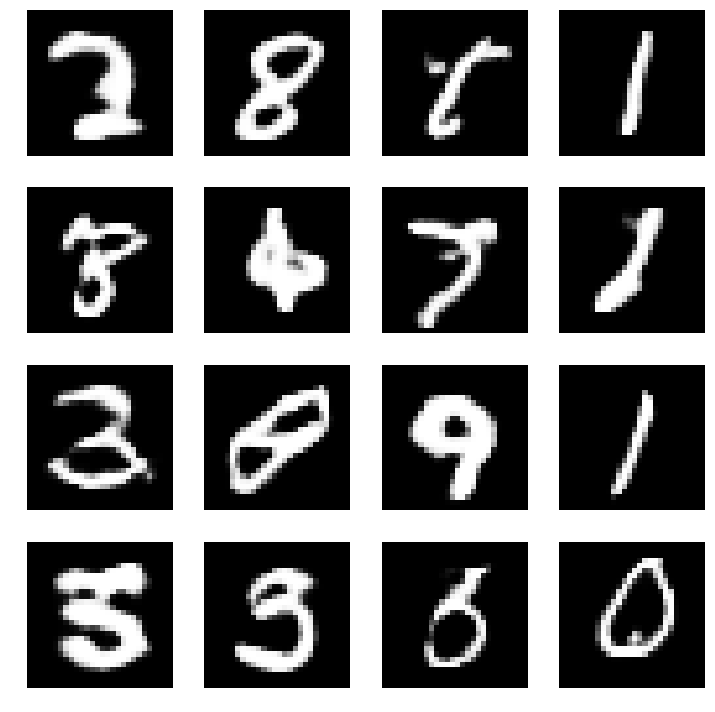

In [58]:
#Create DCGAN for mnist, train DCGAN and plot generated images

if __name__ == '__main__':
    mnist_dcgan = MNIST_DCGAN()
    model_name = 'DCGAN_mnist_model'
    # Prepare model model saving directory.
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    train_steps = 10000
    timer = ElapsedTimer()
    mnist_dcgan.train(train_steps=train_steps, batch_size=256, save_interval=500)
    timer.elapsed_time()
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    mnist_dcgan.generator.save_weights(os.path.join(save_dir, 'generator_{}.hdf5'.format(train_steps)))
    mnist_dcgan.discriminator.save_weights(os.path.join(save_dir, 'discriminator_{}.hdf5'.format(train_steps)))
    mnist_dcgan.plot_images(fake=True)
    mnist_dcgan.plot_images(fake=False, save2file=True)

# Discussion